# Batch GP Baseline Plots for SkyPatrol LCs

This notebook runs `per_camera_gp_baseline` for all `data/skypatrol2/*.csv` files using `df_plot.plot_many_lc`. Adjust the hyperparameters below as needed.



In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

from df_plot import plot_lc_with_residuals, SKYPATROL_CSV_PATHS
from lc_baseline import (
    global_mean_baseline,
    global_median_baseline,
    global_rolling_median_baseline,
    global_rolling_mean_baseline,
    per_camera_mean_baseline,
    per_camera_median_baseline,
    per_camera_trend_baseline,
    per_camera_gp_baseline,
    per_camera_gp_baseline_masked,
)

# Where to save outputs
OUT_DIR = Path("lc_plots/skypatrol_gp")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# GP hyperparameters (tune as desired)
gp_kwargs = {
    "sigma": 0.08,   # mag amplitude; lower to smooth more
    "rho": 150.0,    # characteristic timescale (days); higher to smooth more
    "q": 0.7,        # damping; <1 reduces oscillation
    "jitter": 0.006, # mag floor; set >= median photometric error
}

# Plot params
PLOT_KW = {
    "out_dir": OUT_DIR,
    "out_format": "pdf",  # change to "png" if you prefer
    "show": False,         # set True to display inline (slower)
}

print("Output directory:", OUT_DIR.resolve())

Output directory: /Users/calder/Documents/asassn-variability/calder/lc_plots/skypatrol_gp


# Batch GP baseline plots (SkyPatrol)

Use `plot_lc_with_residuals` with `per_camera_gp_baseline` to process all `data/skypatrol2/*.csv` files.


In [2]:
results = plot_lc_with_residuals(
    dat_paths=SKYPATROL_CSV_PATHS,
    baseline_func=per_camera_gp_baseline,
    baseline_kwargs=gp_kwargs,
    out_path=OUT_DIR,
    out_format="pdf",
    show=False,
)

print(f"Saved {len(results)} files to {OUT_DIR.resolve()}")
for r in results[:5]:
    print("-", r)
if len(results) > 5:
    print("...", len(results) - 5, "more")

Saved 28 files to /Users/calder/Documents/asassn-variability/calder/lc_plots/skypatrol_gp
- lc_plots/skypatrol_gp/120259184943-light-curves_per_camera_gp_baseline_residuals.pdf
- lc_plots/skypatrol_gp/223339338105-light-curves_per_camera_gp_baseline_residuals.pdf
- lc_plots/skypatrol_gp/231929175915-light-curves_per_camera_gp_baseline_residuals.pdf
- lc_plots/skypatrol_gp/25770019815-light-curves_per_camera_gp_baseline_residuals.pdf
- lc_plots/skypatrol_gp/266288137752-light-curves_per_camera_gp_baseline_residuals.pdf
... 23 more


## Baseline function smoke tests

Quick synthetic checks to ensure each baseline variant returns `baseline`, `resid`, and `sigma_resid` with finite values on a small synthetic dataset.


In [3]:
import numpy as np
import pandas as pd

np.random.seed(42)

N = 40
jd = np.arange(N, dtype=float)
trend = 0.002 * jd
noise = np.random.normal(0, 0.01, N)
mag = 15.0 + trend + 0.1 * np.sin(jd / 6.0) + noise
err = np.full(N, 0.02, dtype=float)
cam = np.where(jd < N / 2, "A", "B")

df_synth = pd.DataFrame(
    {
        "JD": jd,
        "mag": mag,
        "error": err,
        "camera#": cam,
    }
)

def check_baseline_output(df, name):
    required = {"baseline", "resid", "sigma_resid"}
    assert required.issubset(df.columns), f"{name}: missing columns"
    finite_baseline = np.isfinite(df["baseline"])
    finite_resid = np.isfinite(df["resid"])
    finite_sigma = np.isfinite(df["sigma_resid"])
    assert finite_baseline.any(), f"{name}: baseline all-NaN"
    assert finite_resid.any(), f"{name}: resid all-NaN"
    assert finite_sigma.any(), f"{name}: sigma_resid all-NaN"
    print(f"{name}: ok ({finite_baseline.sum()} finite baselines)")


In [4]:
from lc_baseline import (
    global_mean_baseline,
    global_median_baseline,
    global_rolling_median_baseline,
    global_rolling_mean_baseline,
    per_camera_mean_baseline,
    per_camera_median_baseline,
    per_camera_trend_baseline,
    per_camera_gp_baseline,
    per_camera_gp_baseline_masked,
)

tests = [
    ("global_mean_baseline", global_mean_baseline, {}),
    ("global_median_baseline", global_median_baseline, {}),
    ("global_rolling_median_baseline", global_rolling_median_baseline, {"days": 40.0, "min_points": 5}),
    ("global_rolling_mean_baseline", global_rolling_mean_baseline, {"days": 20.0, "min_points": 5}),
    ("per_camera_mean_baseline", per_camera_mean_baseline, {}),
    ("per_camera_median_baseline", per_camera_median_baseline, {"days": 40.0, "min_points": 5}),
    (
        "per_camera_trend_baseline",
        per_camera_trend_baseline,
        {"days_short": 40.0, "days_long": 80.0, "min_points": 5, "last_window_guard": 10.0},
    ),
    (
        "per_camera_gp_baseline",
        per_camera_gp_baseline,
        {"sigma": 0.05, "rho": 20.0, "q": 0.7, "jitter": 0.01},
    ),
    (
        "per_camera_gp_baseline_masked",
        per_camera_gp_baseline_masked,
        {"a1": 0.01, "rho1": 50.0, "a2": 0.005, "rho2": 100.0, "jitter": 0.01},
    ),
]

for name, func, kwargs in tests:
    df_out = func(df_synth, **kwargs)
    check_baseline_output(df_out, name)

global_mean_baseline: ok (40 finite baselines)
global_median_baseline: ok (40 finite baselines)
global_rolling_median_baseline: ok (36 finite baselines)
global_rolling_mean_baseline: ok (36 finite baselines)
per_camera_mean_baseline: ok (40 finite baselines)
per_camera_median_baseline: ok (32 finite baselines)
per_camera_trend_baseline: ok (32 finite baselines)
per_camera_gp_baseline: ok (40 finite baselines)
per_camera_gp_baseline_masked: ok (40 finite baselines)


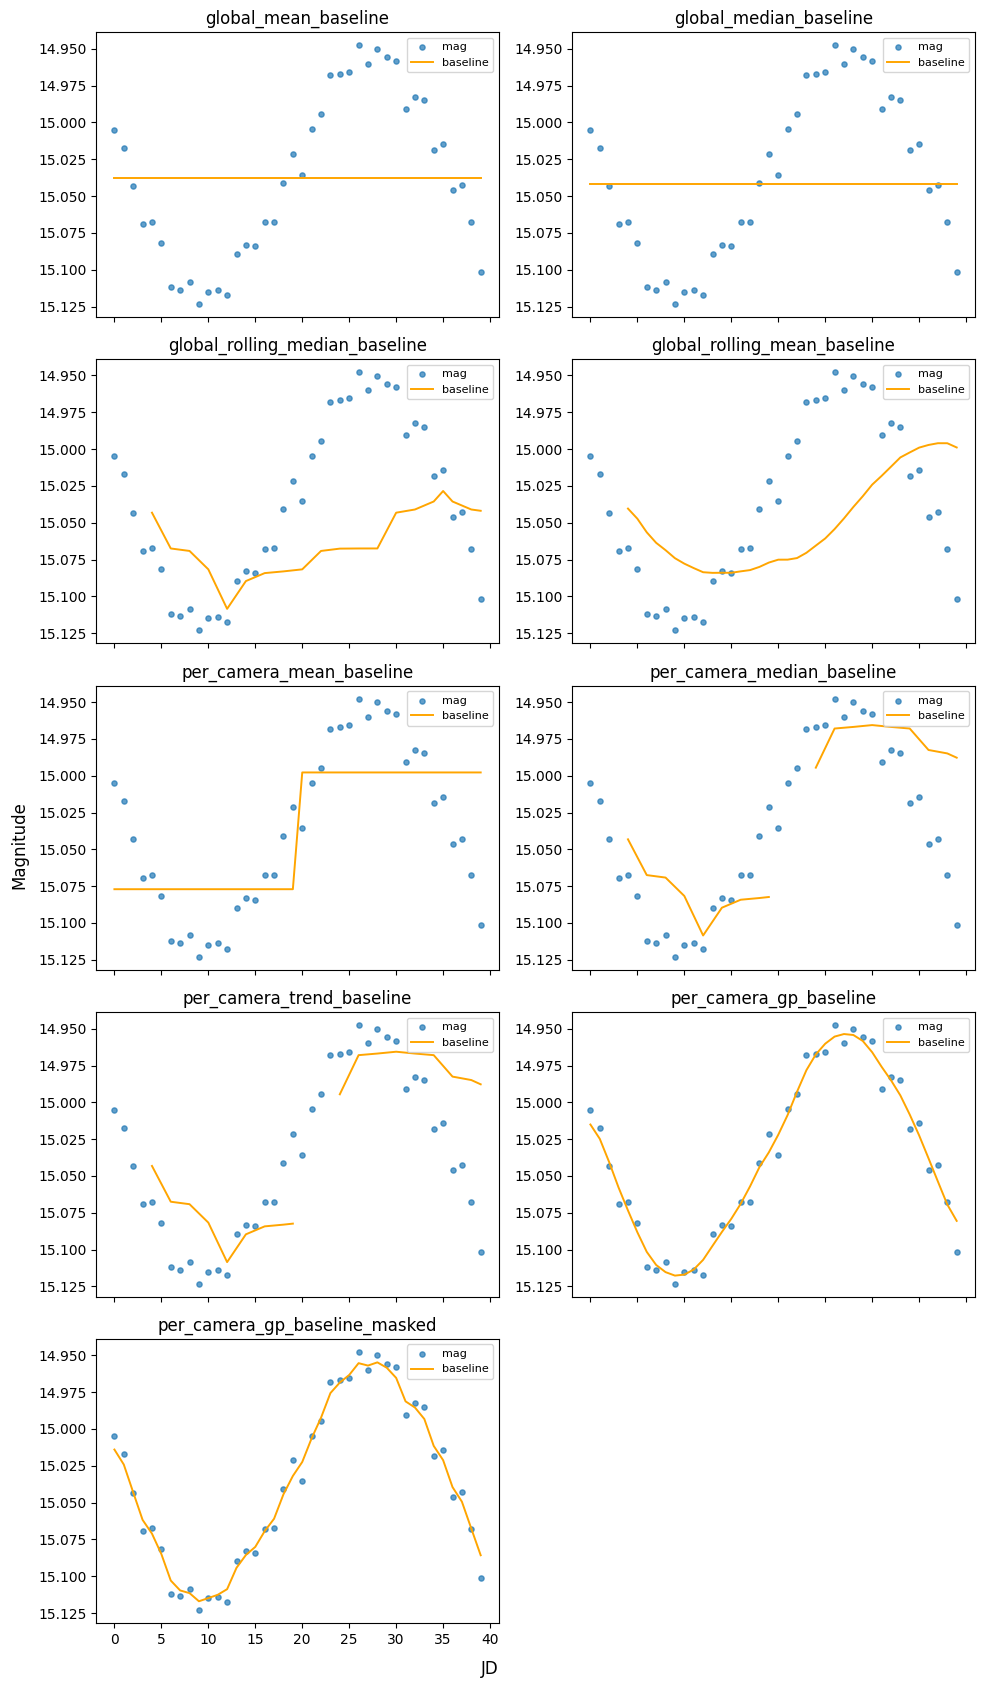

In [5]:

n = len(tests)
ncols = 2
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3.4 * nrows), sharex=True)
axes = axes.flatten()

for ax, (name, func, kwargs) in zip(axes, tests):
    df_out = func(df_synth, **kwargs)
    ax.scatter(df_out["JD"], df_out["mag"], s=14, alpha=0.7, label="mag")
    ax.plot(df_out["JD"], df_out["baseline"], color="orange", lw=1.4, label="baseline")
    ax.set_title(name)
    ax.invert_yaxis()
    ax.legend(loc="best", fontsize=8)

for ax in axes[n:]:
    ax.axis("off")

fig.supxlabel("JD")
fig.supylabel("Magnitude")
plt.tight_layout()
plt.show()



## Batch baselines on SkyPatrol data

Run every baseline function over all `SKYPATROL_CSV_PATHS` and write plots to `lc_plots/skypatrol_all_baselines/<baseline_tag>`. Set `show=False` to avoid inline rendering; adjust kwargs if you want to tune smoothing.


In [6]:
baseline_runs = [
    ("global_mean", global_mean_baseline, {}),
    ("global_median", global_median_baseline, {}),
    ("global_roll_median", global_rolling_median_baseline, {"days": 400.0, "min_points": 15}),
    ("global_roll_mean", global_rolling_mean_baseline, {"days": 400.0, "min_points": 15}),
    ("per_cam_mean", per_camera_mean_baseline, {}),
    ("per_cam_median", per_camera_median_baseline, {"days": 400.0, "min_points": 15}),
    (
        "per_cam_trend",
        per_camera_trend_baseline,
        {"days_short": 200.0, "days_long": 800.0, "min_points": 12, "last_window_guard": 120.0},
    ),
    (
        "per_cam_gp",
        per_camera_gp_baseline,
        {"sigma": 0.08, "rho": 150.0, "q": 0.7, "jitter": 0.006},
    ),
]

OUT_ROOT = Path("lc_plots/skypatrol_all_baselines")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

results_summary = {}
for tag, func, kwargs in baseline_runs:
    out_dir = OUT_ROOT / tag
    out_dir.mkdir(parents=True, exist_ok=True)
    print(f"Running {tag} -> {out_dir} ...")
    files = plot_lc_with_residuals(
        dat_paths=SKYPATROL_CSV_PATHS,
        baseline_func=func,
        baseline_kwargs=kwargs,
        out_path=out_dir,
        out_format="pdf",
        show=False,
        baseline_tag=tag,
    )
    results_summary[tag] = len(files) if files else 0
    print(f"  saved {results_summary[tag]} files")

print("Done. Counts per baseline:")
for tag, count in results_summary.items():
    print(f"- {tag}: {count}")



Running global_mean -> lc_plots/skypatrol_all_baselines/global_mean ...
  saved 28 files
Running global_median -> lc_plots/skypatrol_all_baselines/global_median ...
  saved 28 files
Running global_roll_median -> lc_plots/skypatrol_all_baselines/global_roll_median ...
  saved 28 files
Running global_roll_mean -> lc_plots/skypatrol_all_baselines/global_roll_mean ...
  saved 28 files
Running per_cam_mean -> lc_plots/skypatrol_all_baselines/per_cam_mean ...
  saved 28 files
Running per_cam_median -> lc_plots/skypatrol_all_baselines/per_cam_median ...
  saved 28 files
Running per_cam_trend -> lc_plots/skypatrol_all_baselines/per_cam_trend ...
  saved 28 files
Running per_cam_gp -> lc_plots/skypatrol_all_baselines/per_cam_gp ...
  saved 28 files
Done. Counts per baseline:
- global_mean: 28
- global_median: 28
- global_roll_median: 28
- global_roll_mean: 28
- per_cam_mean: 28
- per_cam_median: 28
- per_cam_trend: 28
- per_cam_gp: 28


## Masked GP Baseline

Runs `per_camera_gp_baseline_masked` which masks out significant dips (thresholded by local MAD) before fitting the GP baseline to ensure the baseline follows the quiescent state rather than the dips.

In [7]:
OUT_DIR_MASKED = Path("lc_plots/skypatrol_gp_masked")
OUT_DIR_MASKED.mkdir(parents=True, exist_ok=True)

# Masked GP hyperparameters
gp_masked_kwargs = {
    "dip_sigma_thresh": -2.5,
    "pad_days": 50.,
    "a1": 0.02**2,
    "rho1": 1000.0,
    "a2": 0.01**2,
    "rho2": 3000.0,
    "jitter": 0.1,
}

print(f"Running per_camera_gp_baseline_masked ...")
results_masked = plot_lc_with_residuals(
    dat_paths=SKYPATROL_CSV_PATHS,
    baseline_func=per_camera_gp_baseline_masked,
    baseline_kwargs=gp_masked_kwargs,
    out_path=OUT_DIR_MASKED,
    out_format="pdf",
    show=False,
    baseline_tag="per_cam_gp_masked"
)

print(f"Done. Saved {len(results_masked)} files to {OUT_DIR_MASKED.resolve()}")

Running per_camera_gp_baseline_masked ...
Done. Saved 28 files to /Users/calder/Documents/asassn-variability/calder/lc_plots/skypatrol_gp_masked


In [8]:
# Debug: Check what the GP masked baseline is actually doing
# This shows how many points are masked per light curve and per camera

from df_plot import read_skypatrol_csv
import numpy as np

def debug_gp_masking(csv_path, gp_kwargs):
    """Show masking statistics for a single light curve."""
    df = read_skypatrol_csv(csv_path)
    source_id = Path(csv_path).stem.replace("-light-curves", "")
    
    print(f"\n{'='*60}")
    print(f"Source: {source_id}")
    print(f"{'='*60}")
    
    for band, band_name in [(0, "g-band"), (1, "V-band")]:
        df_band = df[df["v_g_band"] == band].copy()
        if df_band.empty:
            print(f"  {band_name}: No data")
            continue
            
        # Run baseline
        result = per_camera_gp_baseline_masked(df_band, **gp_kwargs)
        
        n_total = len(result)
        
        # Check masking by looking at residuals relative to median
        y = result["mag"].values
        y_med = np.nanmedian(y)
        r0 = y - y_med
        
        # Robust scale
        r0_finite = r0[np.isfinite(r0)]
        mad = 1.4826 * np.nanmedian(np.abs(r0_finite - np.nanmedian(r0_finite)))
        e_med = np.nanmedian(result["error"].values)
        s0 = np.sqrt(mad**2 + e_med**2)
        
        sig0 = r0 / s0
        n_below_thresh = (sig0 < gp_kwargs["dip_sigma_thresh"]).sum()
        
        # Check final residuals
        resid = result["resid"].values
        sigma_resid = result["sigma_resid"].values
        
        n_significant_dips = (sigma_resid < -3).sum()
        max_dip_sigma = np.nanmin(sigma_resid)
        max_dip_resid = np.nanmax(resid[np.isfinite(resid)])  # positive resid = dip
        
        print(f"\n  {band_name}:")
        print(f"    Total points: {n_total}")
        print(f"    Points flagged as dips (< {gp_kwargs['dip_sigma_thresh']}σ): {n_below_thresh}")
        print(f"    Points masked (incl. padding): ~{n_below_thresh} + neighbors")
        print(f"    Final significant dips (< -3σ): {n_significant_dips}")
        print(f"    Max dip depth: {max_dip_resid:.3f} mag ({max_dip_sigma:.1f}σ)")
        print(f"    Baseline scatter (MAD): {mad:.4f} mag")
        
        # Per-camera breakdown
        print(f"    Per-camera stats:")
        for cam in sorted(result["camera#"].unique()):
            cam_data = result[result["camera#"] == cam]
            cam_dips = (cam_data["sigma_resid"] < -3).sum()
            print(f"      Camera {cam}: {len(cam_data)} pts, {cam_dips} dips")

# Test on a few interesting sources
test_sources = [
    "data/skypatrol2/532576686103-light-curves.csv",  # Big dipper
    "data/skypatrol2/68720274411-light-curves.csv",   # Eclipse binary
    "data/skypatrol2/438086977939-light-curves.csv",  # Single eclipse
]

print("GP Masked Kwargs:", gp_masked_kwargs)
for src in test_sources:
    debug_gp_masking(src, gp_masked_kwargs)


GP Masked Kwargs: {'dip_sigma_thresh': -2.5, 'pad_days': 50.0, 'a1': 0.0004, 'rho1': 1000.0, 'a2': 0.0001, 'rho2': 3000.0, 'jitter': 0.1}

Source: 532576686103

  g-band:
    Total points: 1198
    Points flagged as dips (< -2.5σ): 0
    Points masked (incl. padding): ~0 + neighbors
    Final significant dips (< -3σ): 211
    Max dip depth: 1.411 mag (-66.3σ)
    Baseline scatter (MAD): 0.0866 mag
    Per-camera stats:
      Camera bE: 438 pts, 57 dips
      Camera bi: 538 pts, 111 dips
      Camera bm: 222 pts, 43 dips

  V-band:
    Total points: 266
    Points flagged as dips (< -2.5σ): 4
    Points masked (incl. padding): ~4 + neighbors
    Final significant dips (< -3σ): 50
    Max dip depth: 0.044 mag (-7.5σ)
    Baseline scatter (MAD): 0.0186 mag
    Per-camera stats:
      Camera be: 266 pts, 50 dips

Source: 68720274411

  g-band:
    Total points: 1022
    Points flagged as dips (< -2.5σ): 21
    Points masked (incl. padding): ~21 + neighbors
    Final significant dips (< -3σ

GP params (-1σ, 100d): {'dip_sigma_thresh': -1.0, 'pad_days': 100.0, 'a1': 0.0004, 'rho1': 1000.0, 'a2': 0.0001, 'rho2': 3000.0, 'jitter': 0.006}
60130040391 V-band: 0 dips (>3σ), max dip = 0.051 mag
60130040391 g-band: 135 dips (>3σ), max dip = 1.260 mag


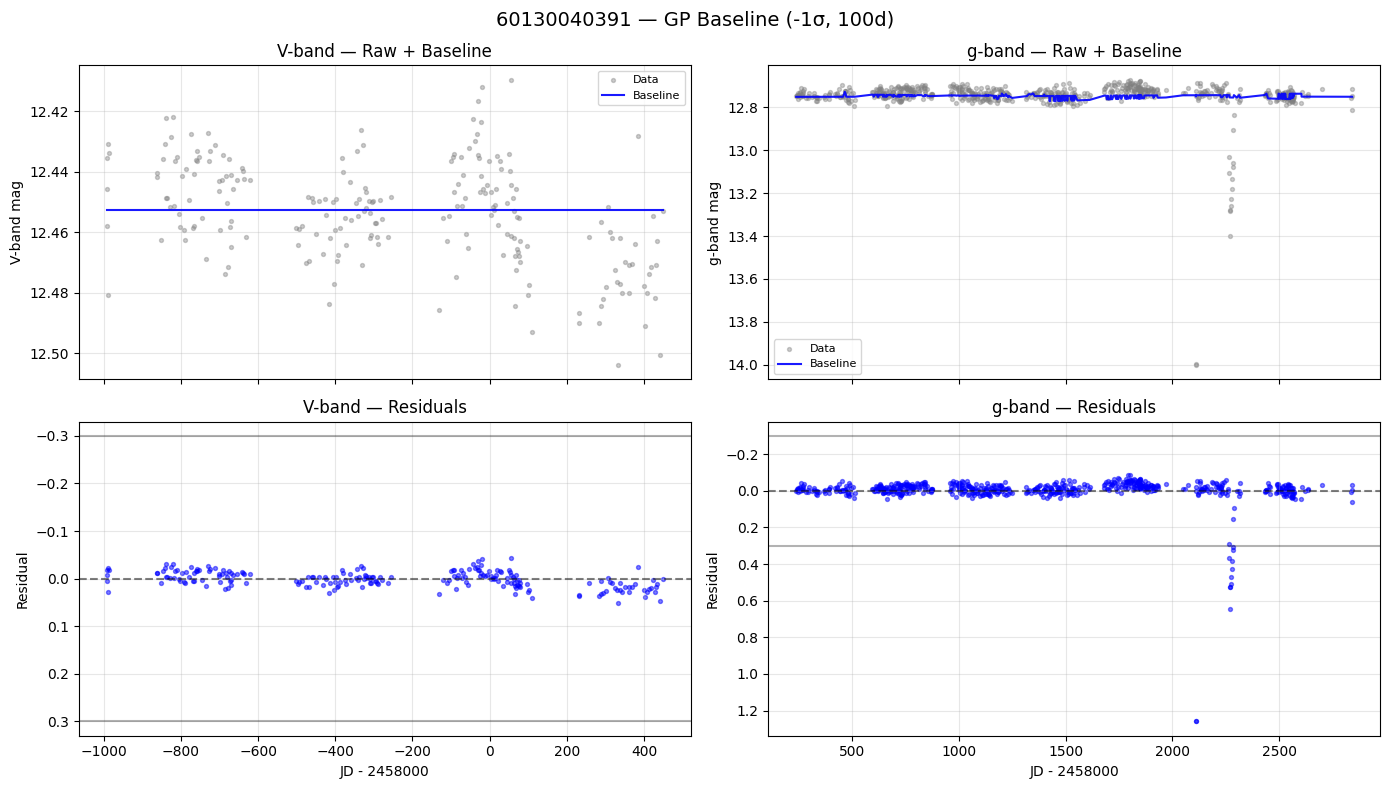

68720274411 V-band: 4 dips (>3σ), max dip = 0.397 mag
68720274411 g-band: 88 dips (>3σ), max dip = 0.756 mag


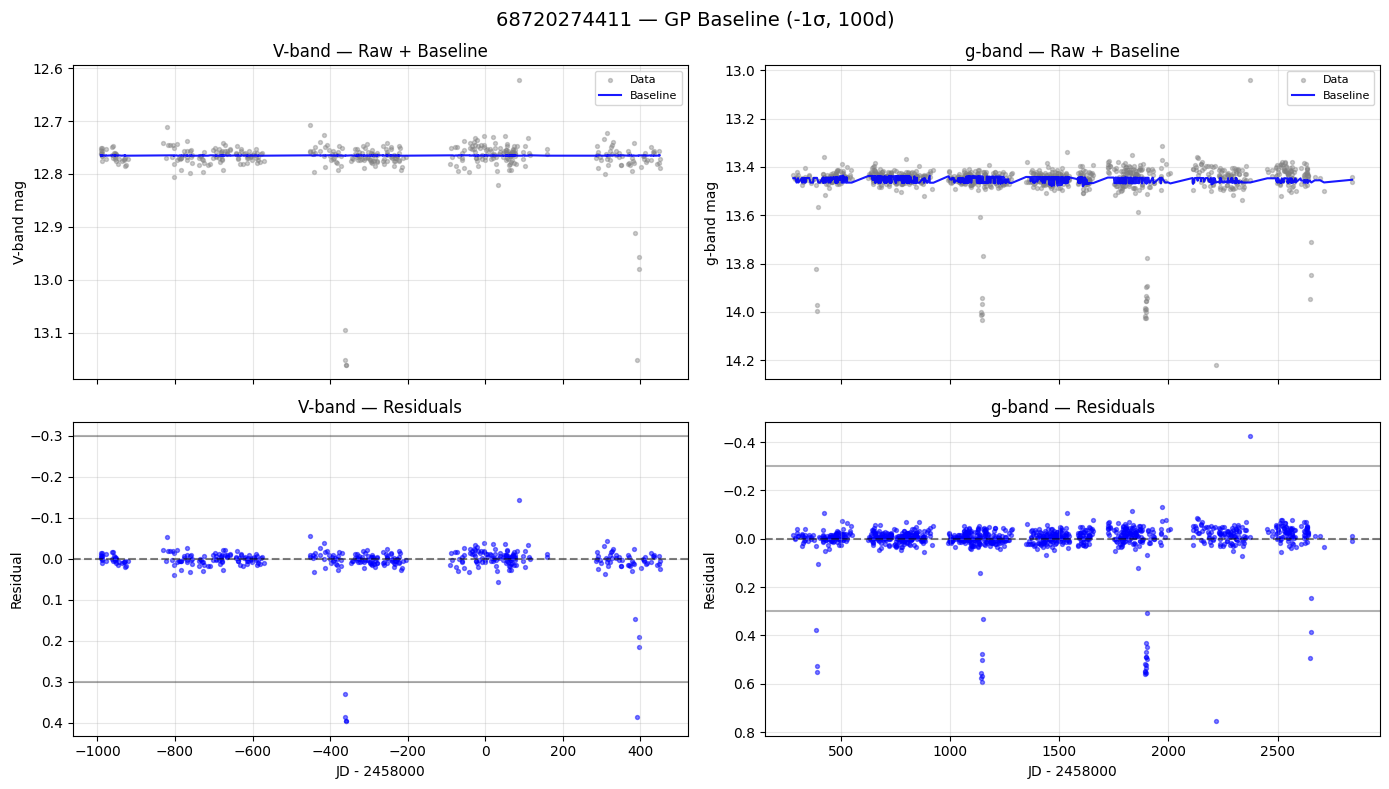

120259184943 V-band: 10 dips (>3σ), max dip = 0.084 mag
120259184943 g-band: 362 dips (>3σ), max dip = 0.762 mag


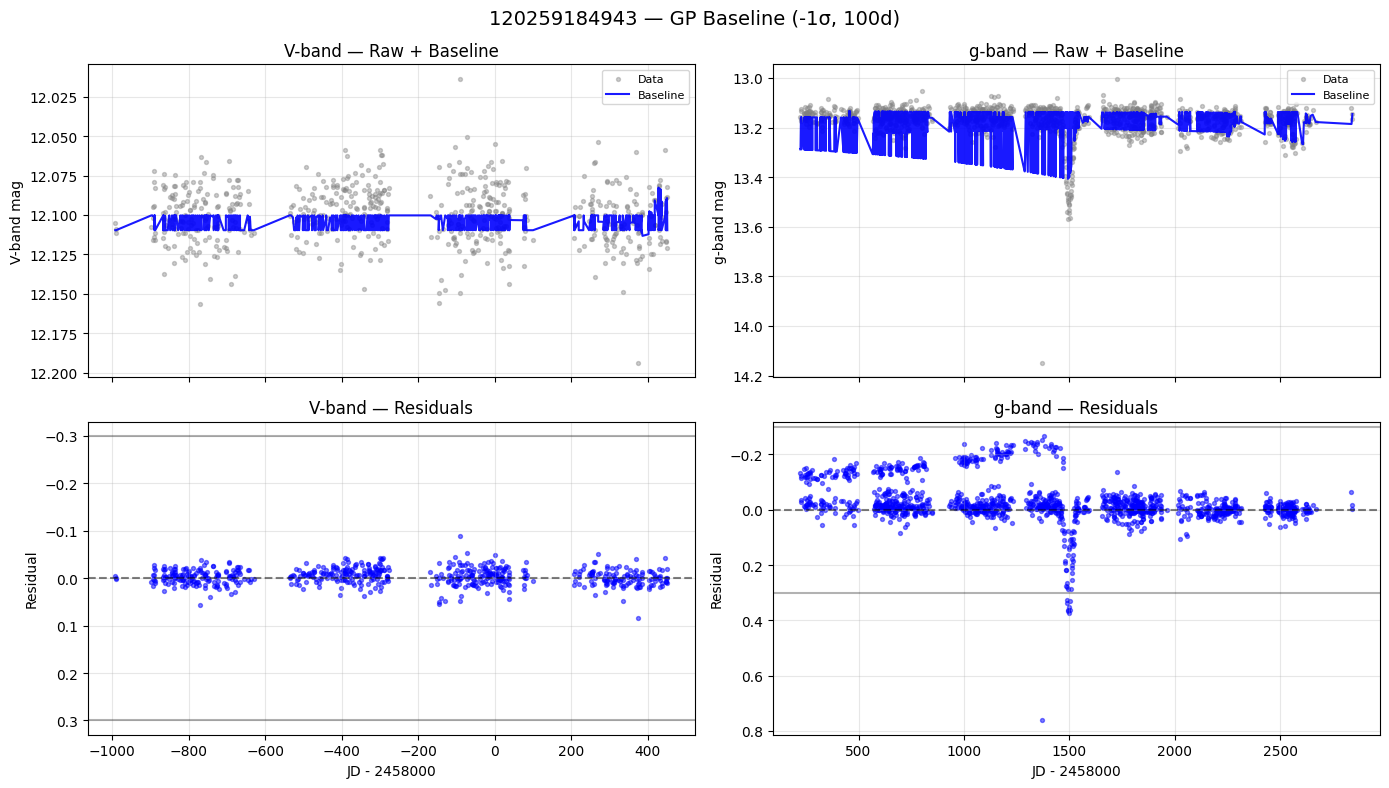

223339338105 V-band: 214 dips (>3σ), max dip = 0.237 mag
223339338105 g-band: 570 dips (>3σ), max dip = 0.476 mag


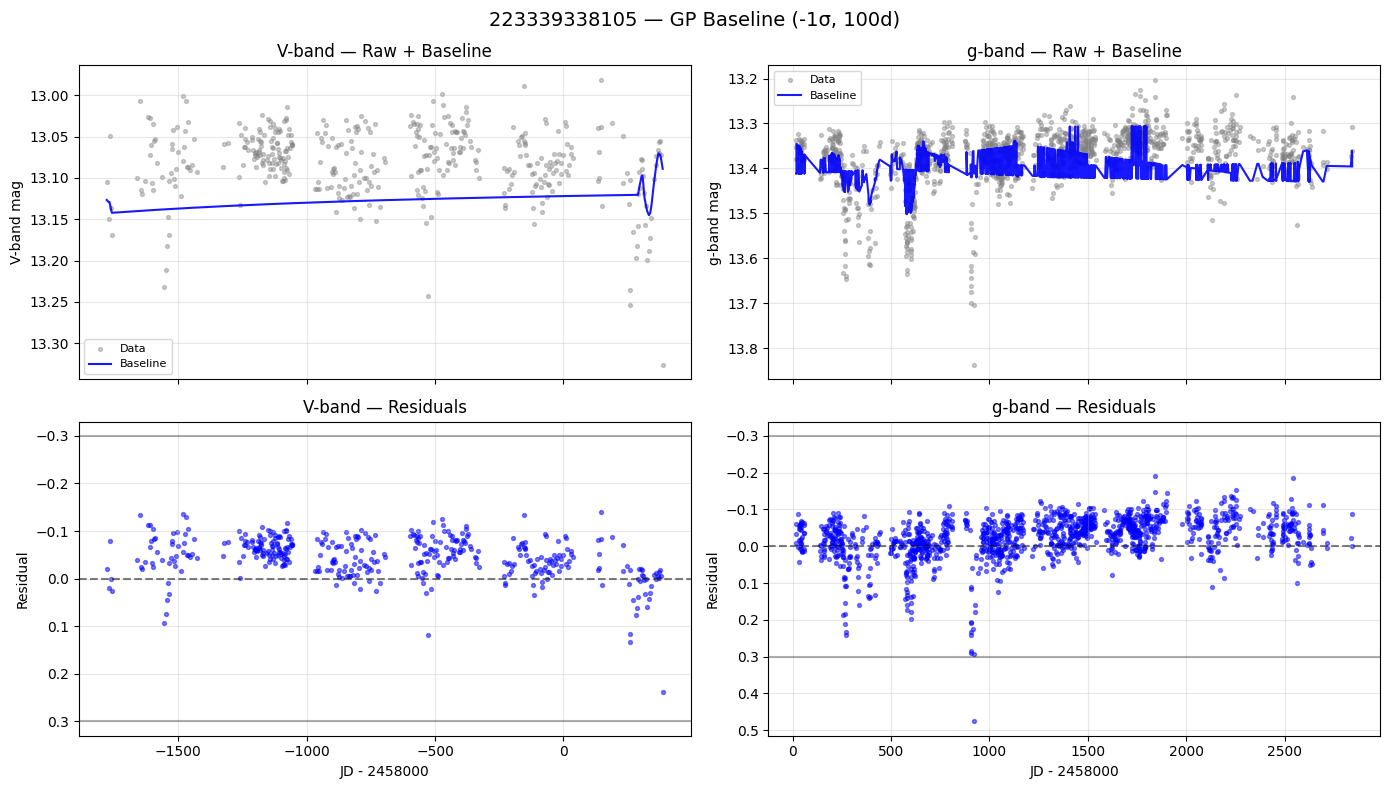

377957522430 V-band: 23 dips (>3σ), max dip = 0.476 mag
377957522430 g-band: 538 dips (>3σ), max dip = 0.827 mag


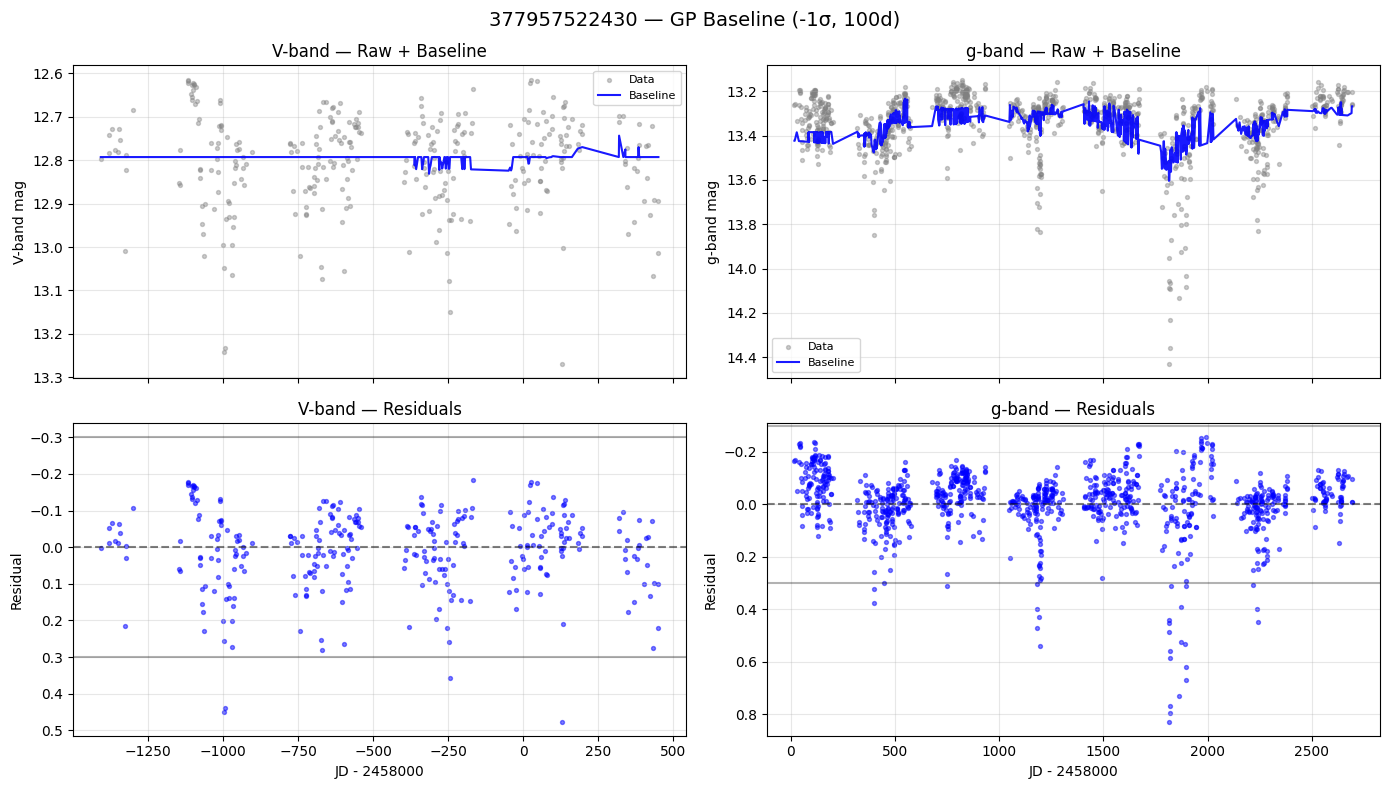

438086977939 V-band: 1 dips (>3σ), max dip = 1.479 mag
438086977939 g-band: 256 dips (>3σ), max dip = 0.274 mag


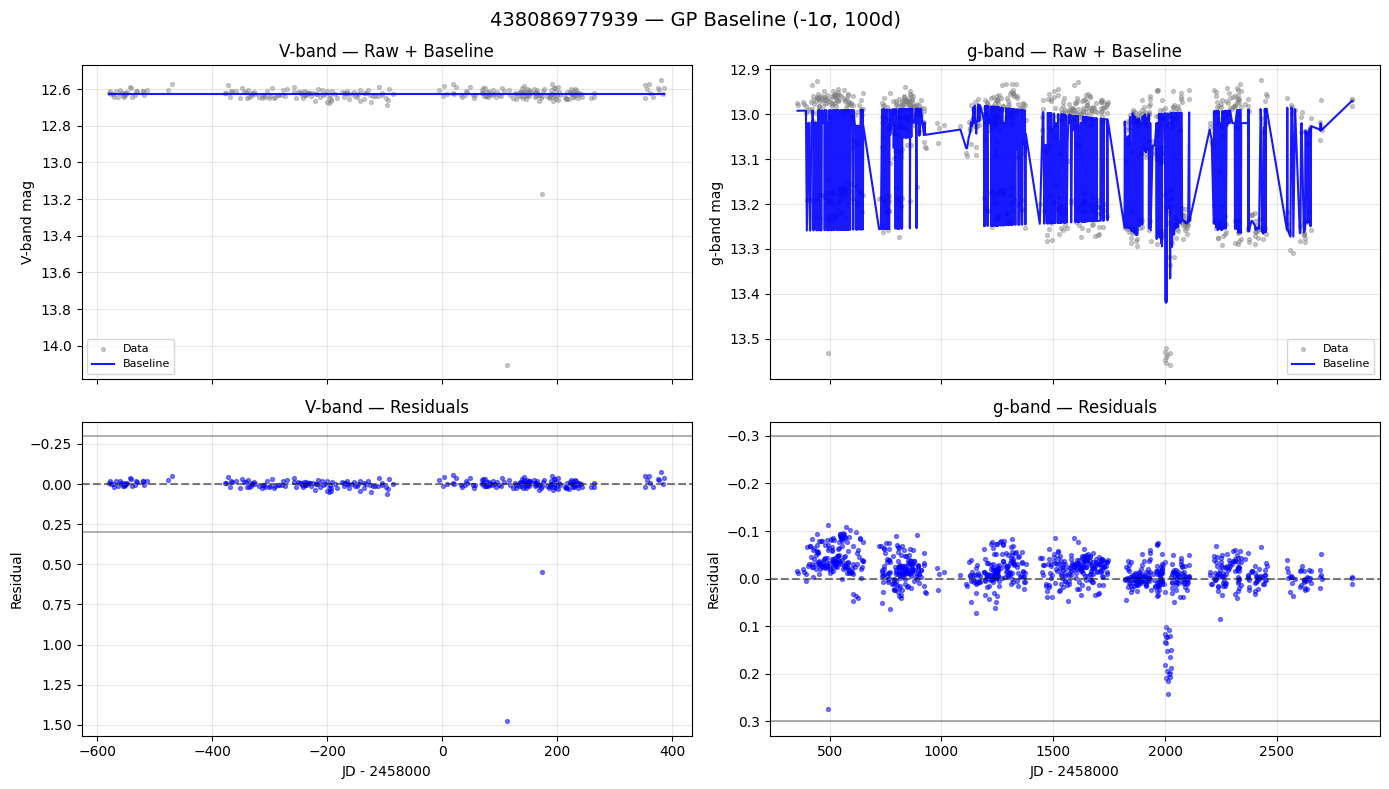

472447294641 V-band: 0 dips (>3σ), max dip = 0.137 mag
472447294641 g-band: 603 dips (>3σ), max dip = 0.239 mag


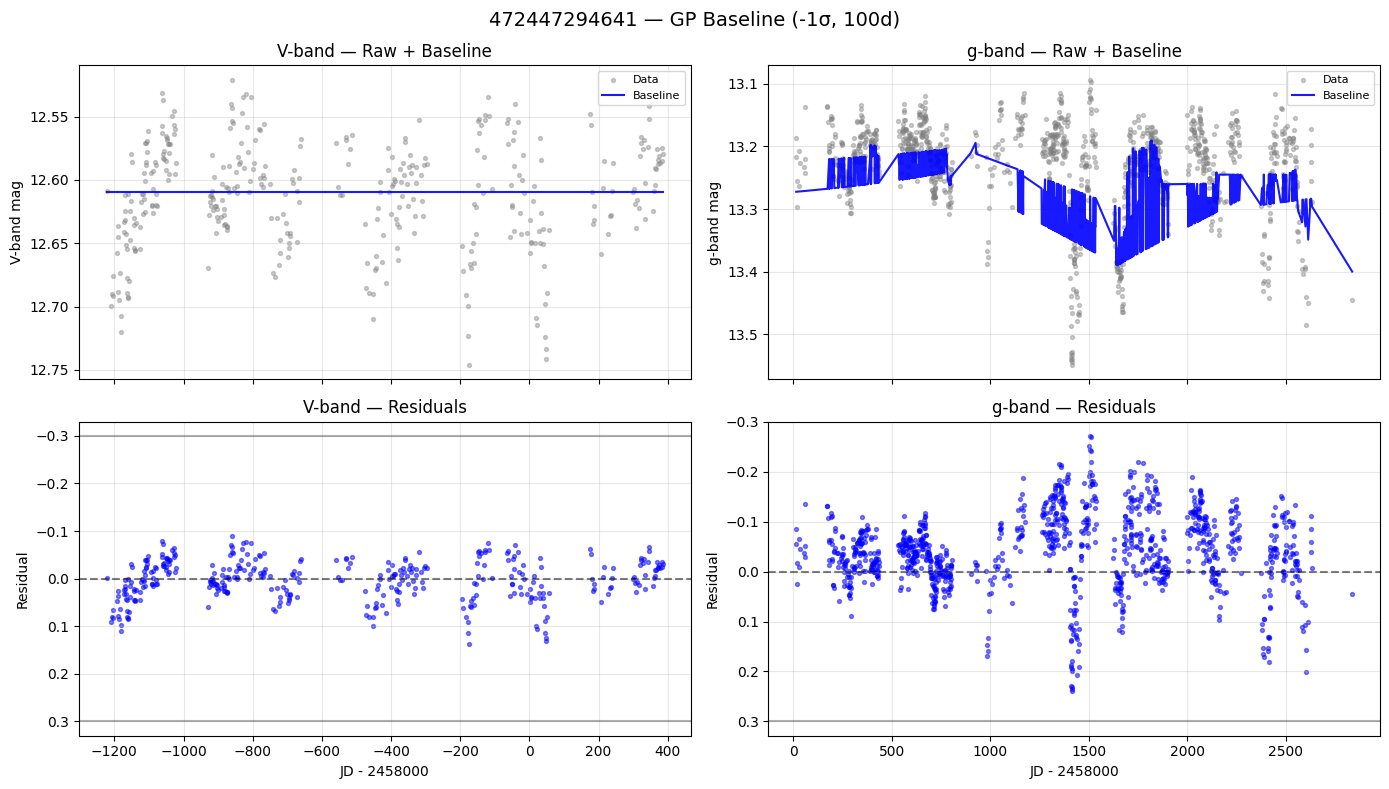

515396514761 V-band: 3 dips (>3σ), max dip = 0.049 mag
515396514761 g-band: 130 dips (>3σ), max dip = 0.388 mag


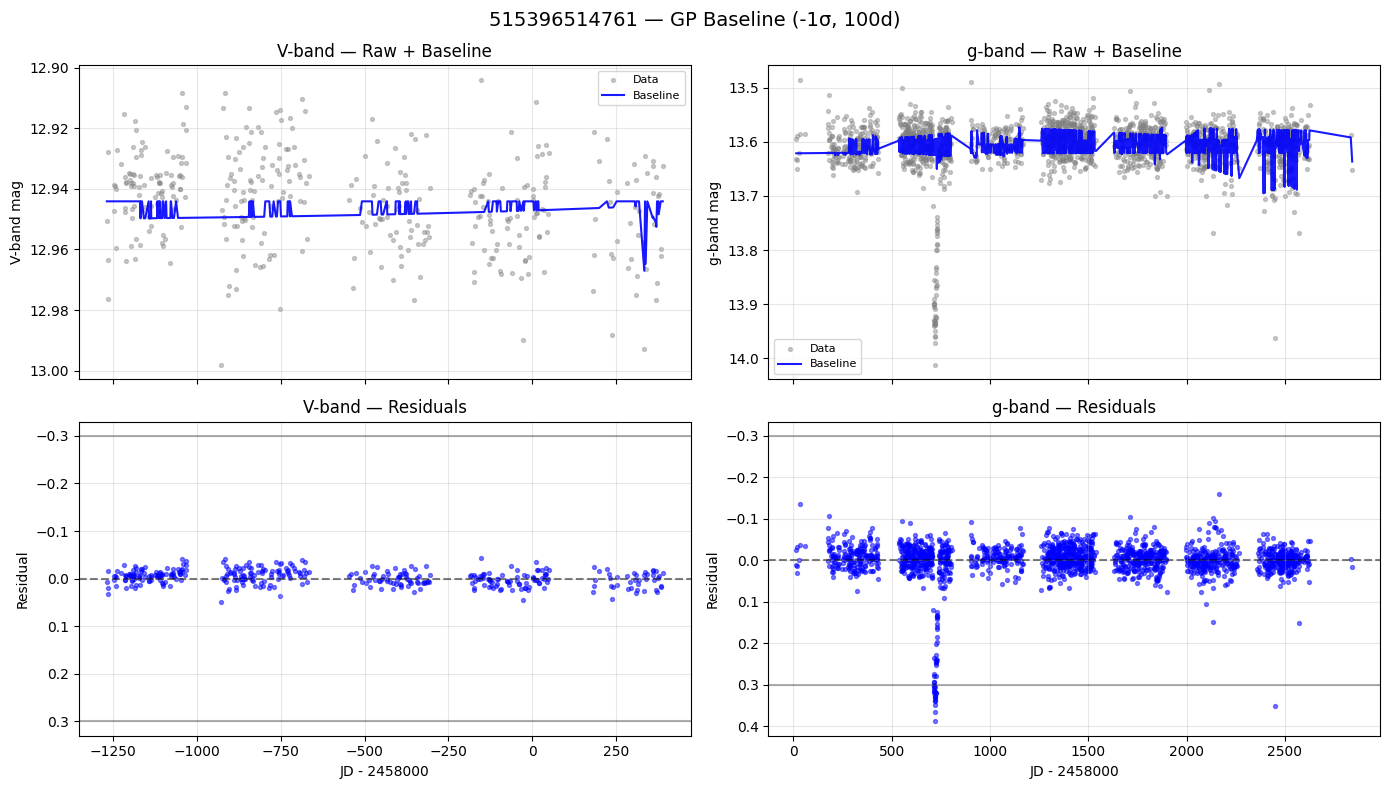

532576686103 V-band: 18 dips (>3σ), max dip = 0.043 mag
532576686103 g-band: 386 dips (>3σ), max dip = 1.410 mag


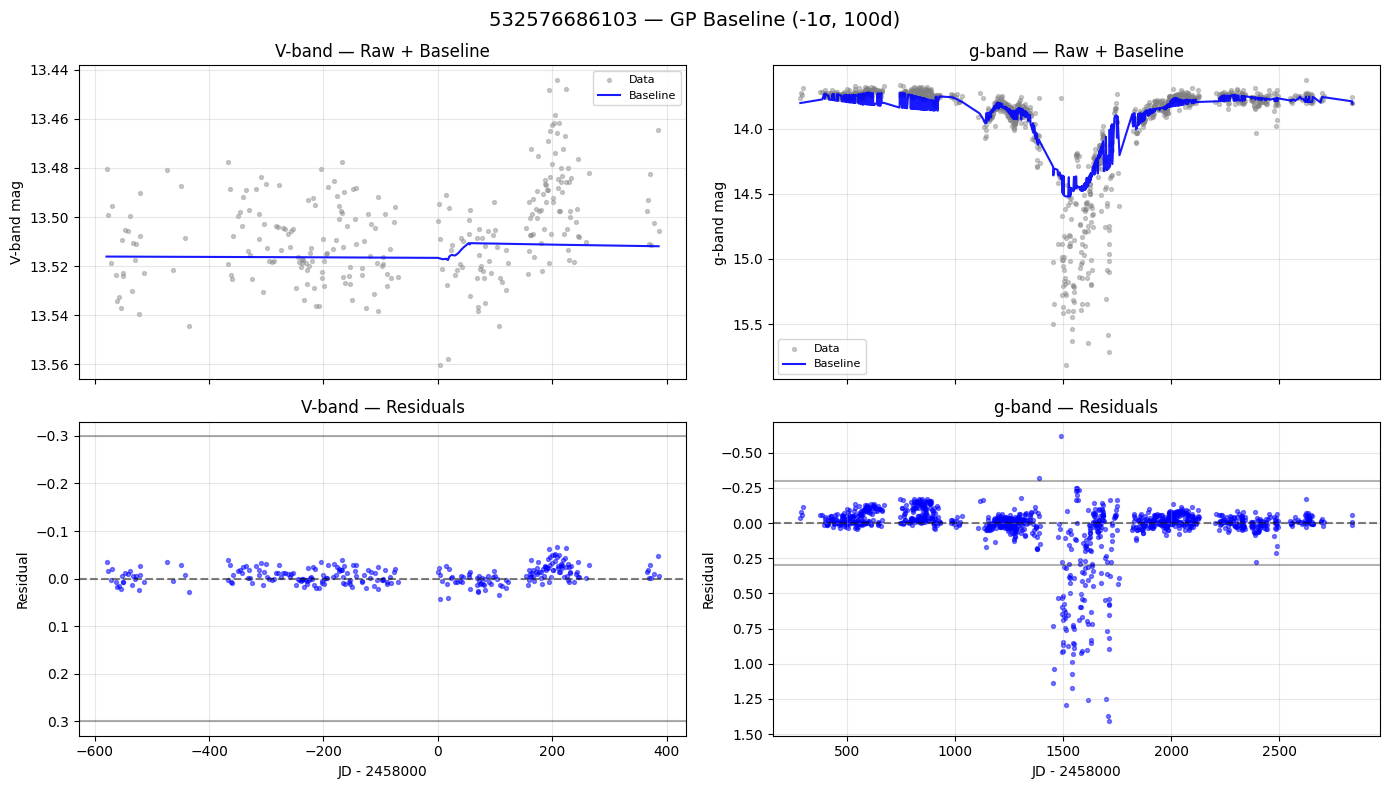

In [9]:
# Compare THREE sets of GP hyperparameters side-by-side

import matplotlib.pyplot as plt
from df_plot import read_skypatrol_csv
import numpy as np

# Single parameter set: -1σ, 100d
gp_params = {
    "dip_sigma_thresh": -1.0,
    "pad_days": 100.0,
    "a1": 0.02**2,
    "rho1": 1000.0,
    "a2": 0.01**2,
    "rho2": 3000.0,
    "jitter": 0.006,
}

def plot_gp_baseline(csv_path, params):
    """Plot GP baseline for a single light curve."""
    df = read_skypatrol_csv(csv_path)
    source_id = Path(csv_path).stem.replace("-light-curves", "")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex='col')
    fig.suptitle(f"{source_id} — GP Baseline (-1σ, 100d)", fontsize=14)
    
    for col, (band, band_name) in enumerate([(1, "V-band"), (0, "g-band")]):
        df_band = df[df["v_g_band"] == band].copy()
        if df_band.empty:
            for row in range(2):
                axes[row, col].text(0.5, 0.5, f"No {band_name} data", ha='center', va='center')
                axes[row, col].set_title(f"{band_name}")
            continue
        
        result = per_camera_gp_baseline_masked(df_band.copy(), **params)
        
        jd = result["JD"].values - 2458000
        mag = result["mag"].values
        
        # Plot raw + baseline
        ax_top = axes[0, col]
        ax_top.scatter(jd, mag, s=8, alpha=0.4, c='gray', label='Data')
        ax_top.plot(jd, result["baseline"].values, '-', color='blue', lw=1.5, alpha=0.9, label='Baseline')
        ax_top.invert_yaxis()
        ax_top.set_ylabel(f"{band_name} mag")
        ax_top.set_title(f"{band_name} — Raw + Baseline")
        ax_top.legend(loc='best', fontsize=8)
        ax_top.grid(True, alpha=0.3)
        
        # Plot residuals
        ax_bot = axes[1, col]
        ax_bot.scatter(jd, result["resid"].values, s=8, alpha=0.5, c='blue')
        ax_bot.axhline(0, color='k', linestyle='--', alpha=0.5)
        ax_bot.axhline(0.3, color='k', linestyle='-', alpha=0.3)
        ax_bot.axhline(-0.3, color='k', linestyle='-', alpha=0.3)
        ax_bot.invert_yaxis()
        ax_bot.set_ylabel("Residual")
        ax_bot.set_xlabel("JD - 2458000")
        ax_bot.set_title(f"{band_name} — Residuals")
        ax_bot.grid(True, alpha=0.3)
        
        # Print stats
        n_dips = (result["sigma_resid"] < -3).sum()
        max_dip = np.nanmax(result["resid"].values)
        print(f"{source_id} {band_name}: {n_dips} dips (>3σ), max dip = {max_dip:.3f} mag")
    
    plt.tight_layout()
    plt.show()
    return fig

# Compare on key sources
test_sources = [
    "data/skypatrol2/60130040391-light-curves.csv",
    "data/skypatrol2/68720274411-light-curves.csv",
    "data/skypatrol2/120259184943-light-curves.csv",
    "data/skypatrol2/223339338105-light-curves.csv",
    "data/skypatrol2/377957522430-light-curves.csv",
    "data/skypatrol2/438086977939-light-curves.csv",
    "data/skypatrol2/472447294641-light-curves.csv",
    "data/skypatrol2/515396514761-light-curves.csv",
    "data/skypatrol2/532576686103-light-curves.csv",
]

print("=" * 70)
print("GP params (-1σ, 100d):", gp_params)
print("=" * 70)

for src in test_sources:
    plot_gp_baseline(src, gp_params)


RealTerm params: {'a1': 0.0004, 'rho1': 1000.0, 'a2': 0.0001, 'rho2': 3000.0}
SHOTerm params: {'sigma': 0.08, 'rho': 150.0, 'Q': 0.7}
Masking: {'dip_sigma_thresh': -1.0, 'pad_days': 100.0, 'jitter': 0.006}
60130040391 V-band: RealTerm 0 dips, SHOTerm 0 dips
60130040391 g-band: RealTerm 135 dips, SHOTerm 5 dips


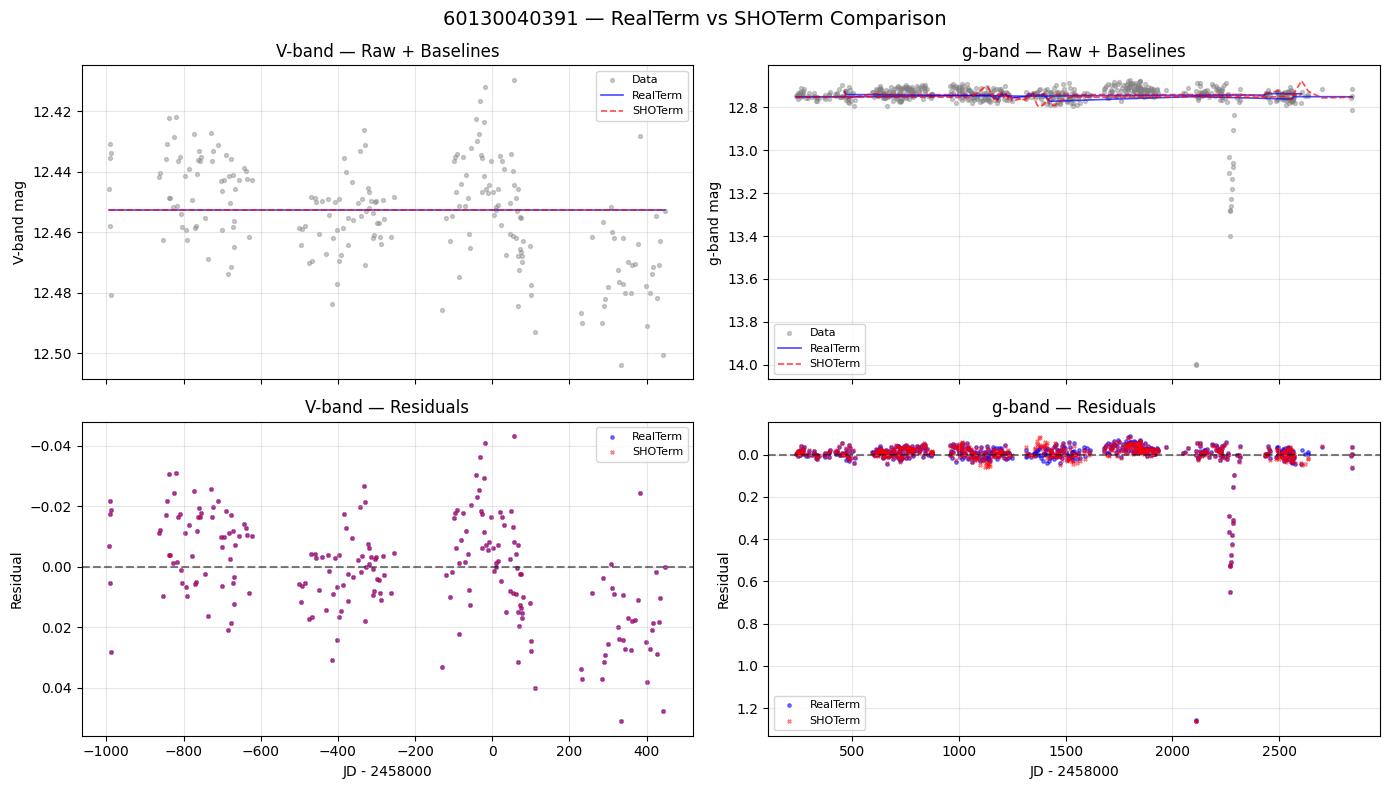

68720274411 V-band: RealTerm 4 dips, SHOTerm 4 dips
68720274411 g-band: RealTerm 88 dips, SHOTerm 16 dips


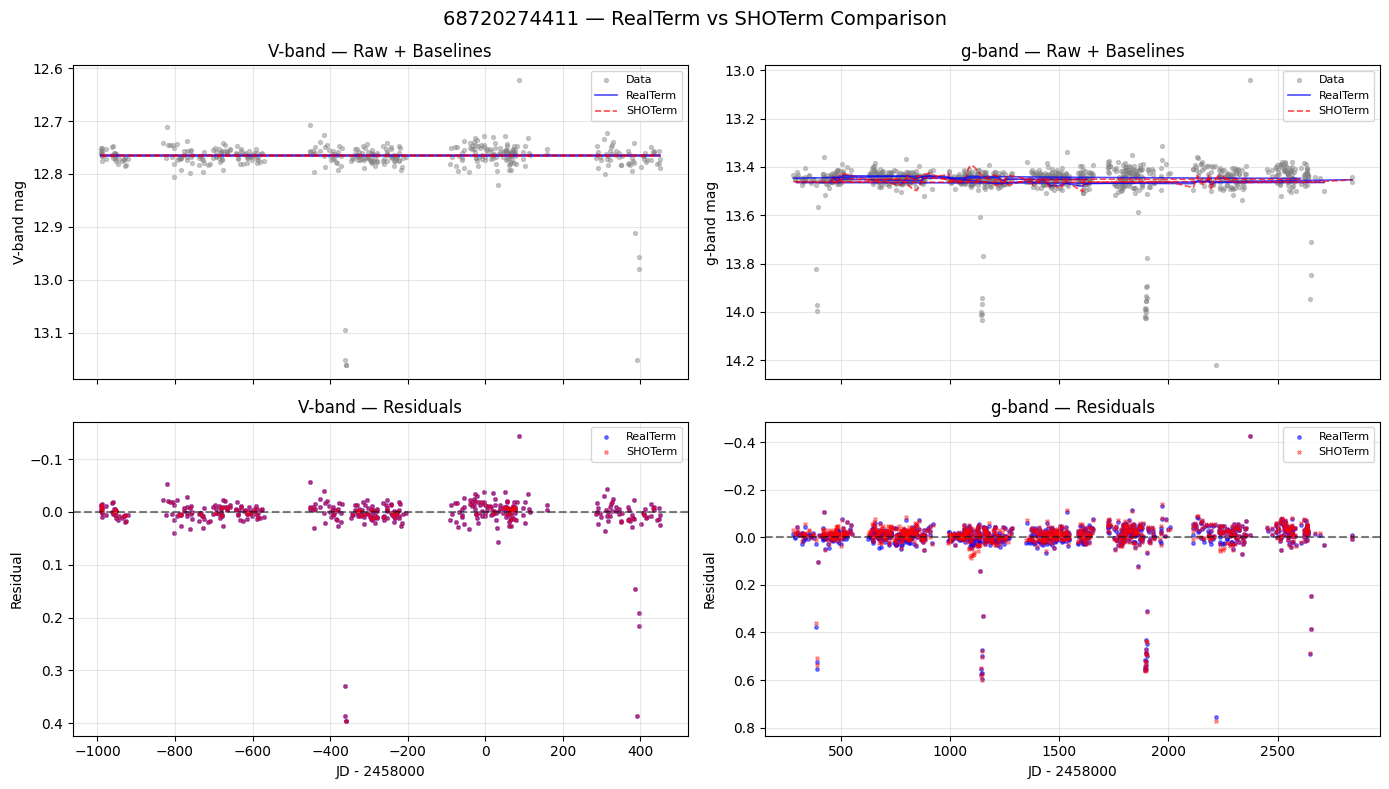

120259184943 V-band: RealTerm 10 dips, SHOTerm 3 dips
120259184943 g-band: RealTerm 362 dips, SHOTerm 9 dips


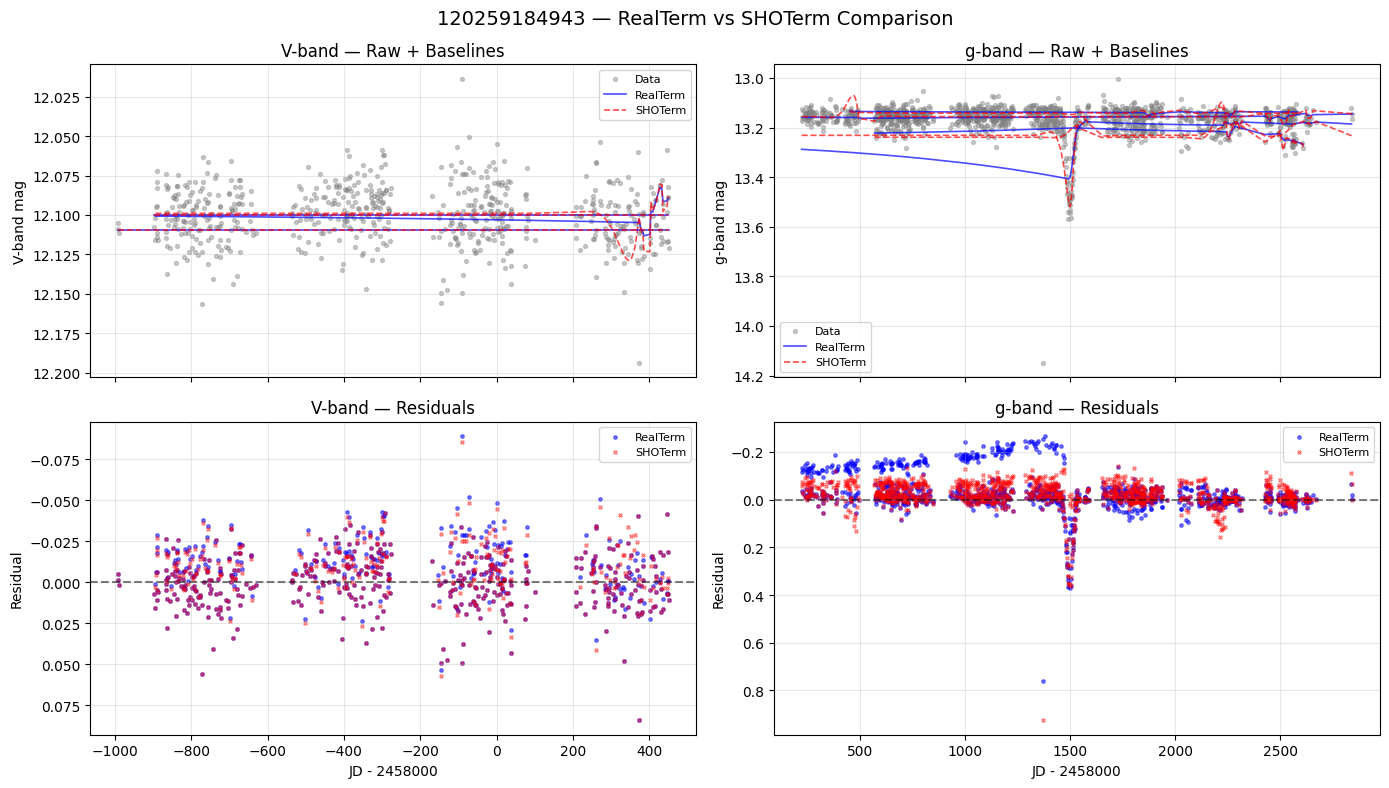

223339338105 V-band: RealTerm 214 dips, SHOTerm 3 dips
223339338105 g-band: RealTerm 570 dips, SHOTerm 49 dips


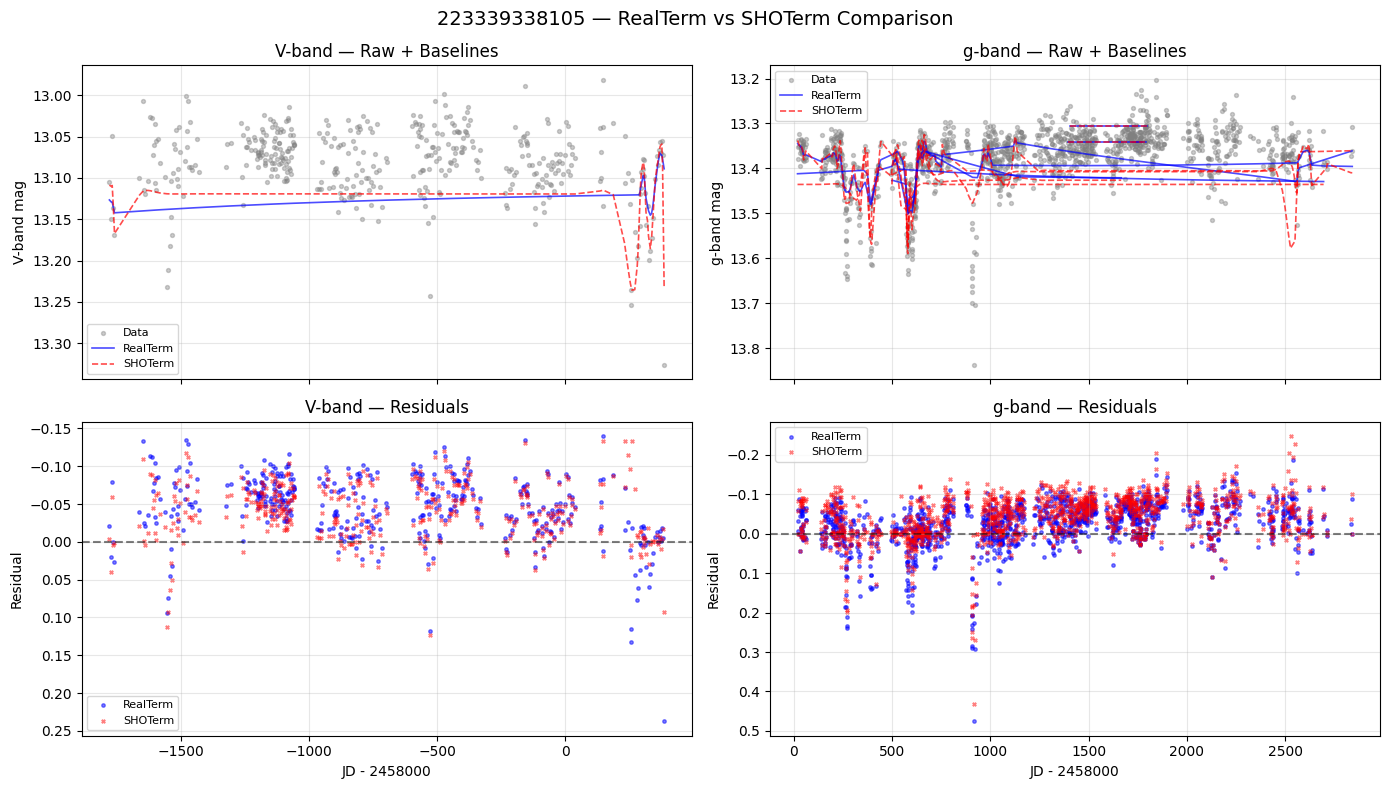

377957522430 V-band: RealTerm 23 dips, SHOTerm 9 dips
377957522430 g-band: RealTerm 538 dips, SHOTerm 119 dips


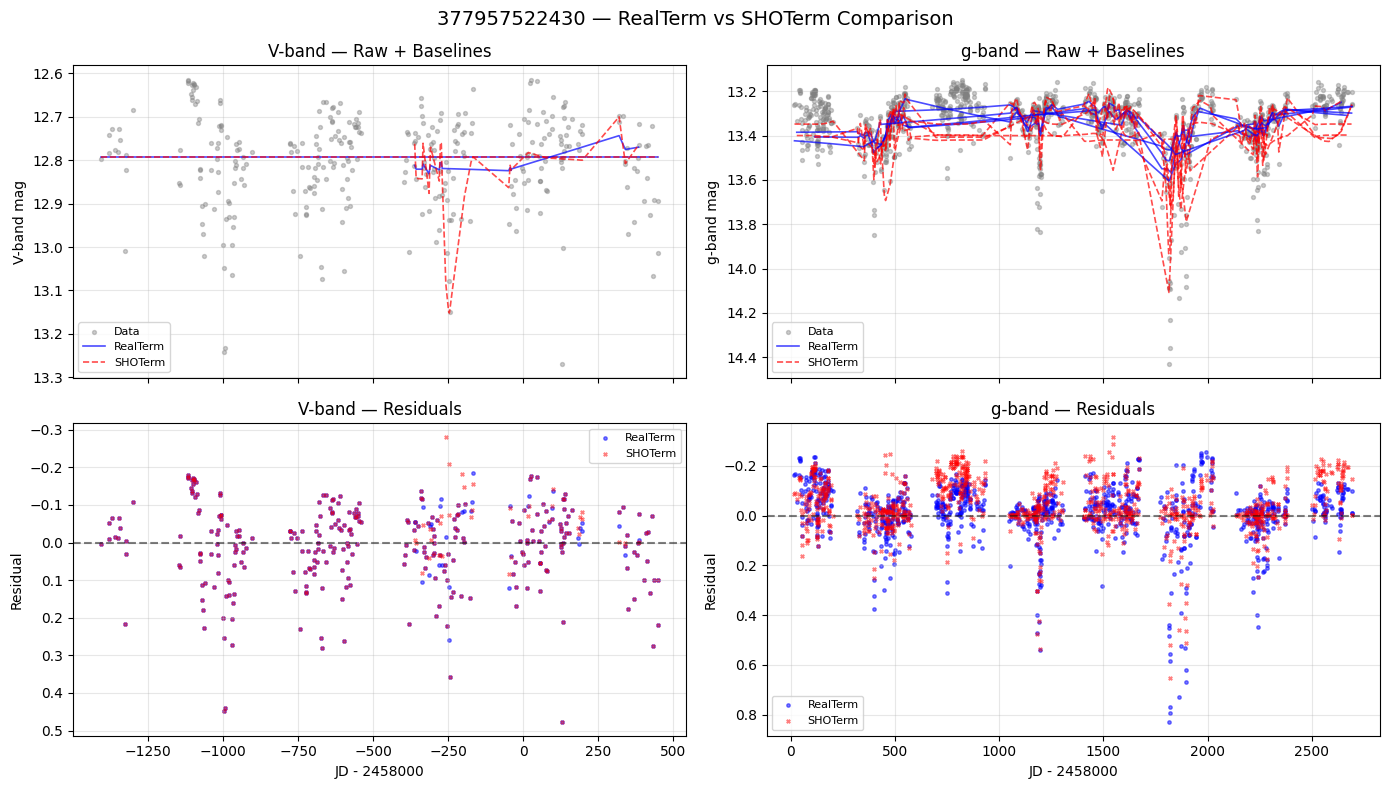

438086977939 V-band: RealTerm 1 dips, SHOTerm 1 dips
438086977939 g-band: RealTerm 256 dips, SHOTerm 52 dips


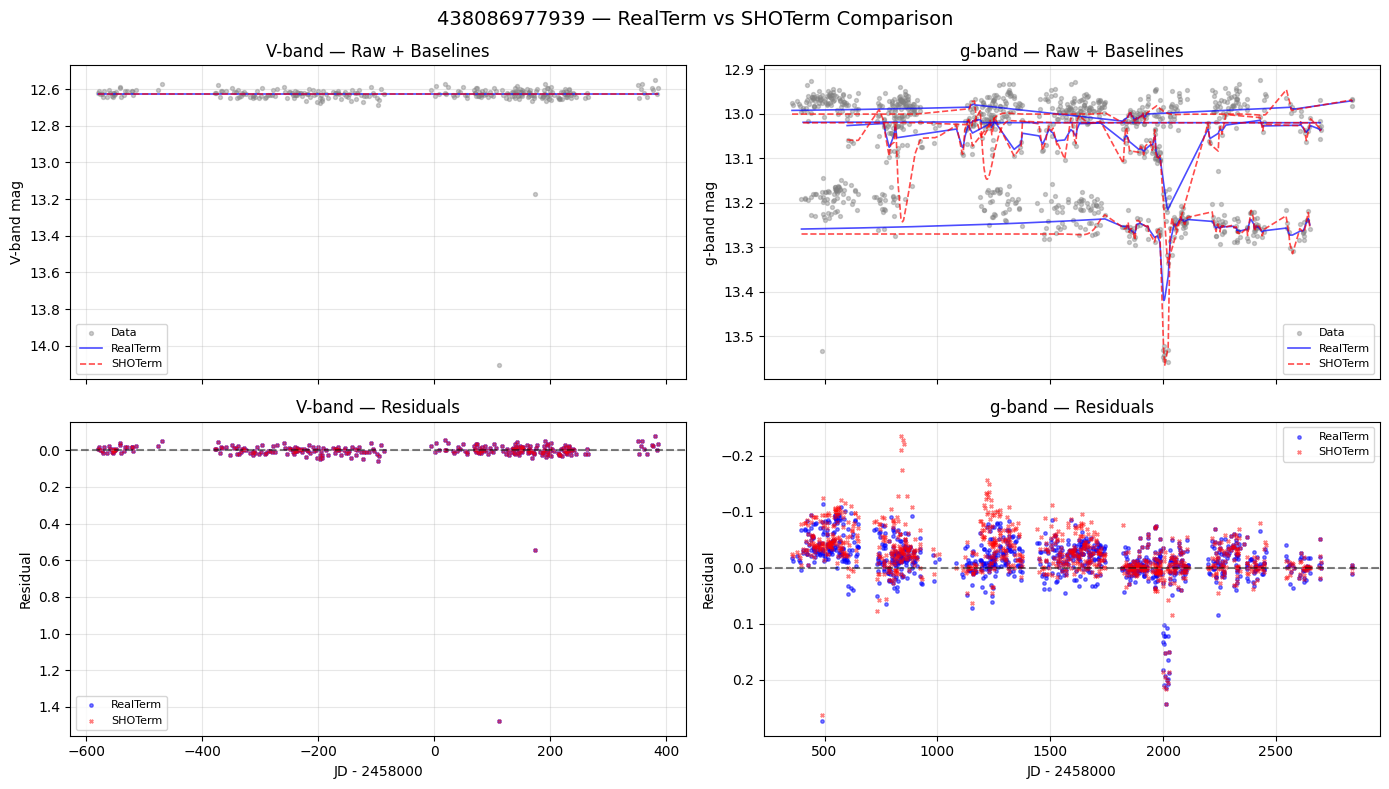

472447294641 V-band: RealTerm 0 dips, SHOTerm 0 dips
472447294641 g-band: RealTerm 603 dips, SHOTerm 13 dips


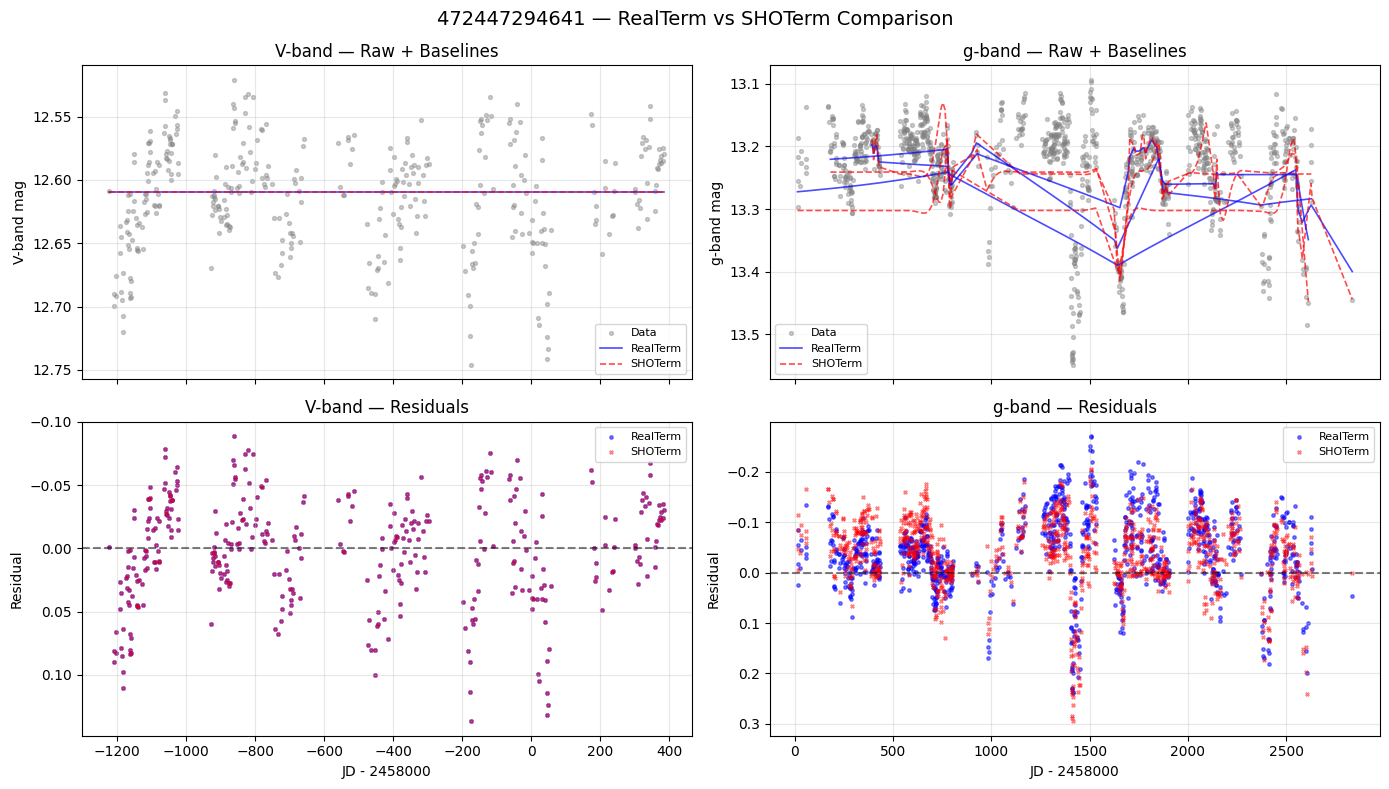

515396514761 V-band: RealTerm 3 dips, SHOTerm 1 dips
515396514761 g-band: RealTerm 130 dips, SHOTerm 15 dips


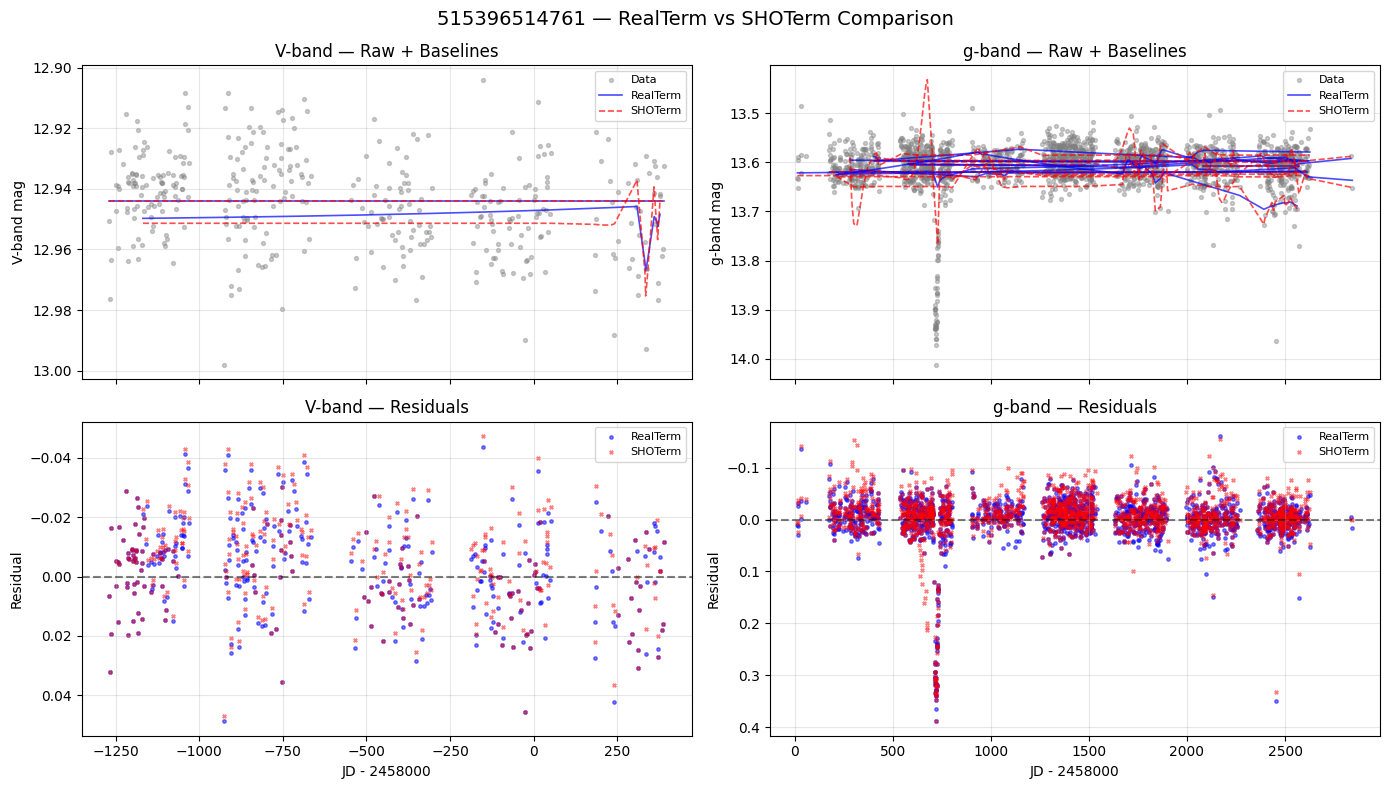

532576686103 V-band: RealTerm 18 dips, SHOTerm 1 dips
532576686103 g-band: RealTerm 386 dips, SHOTerm 476 dips


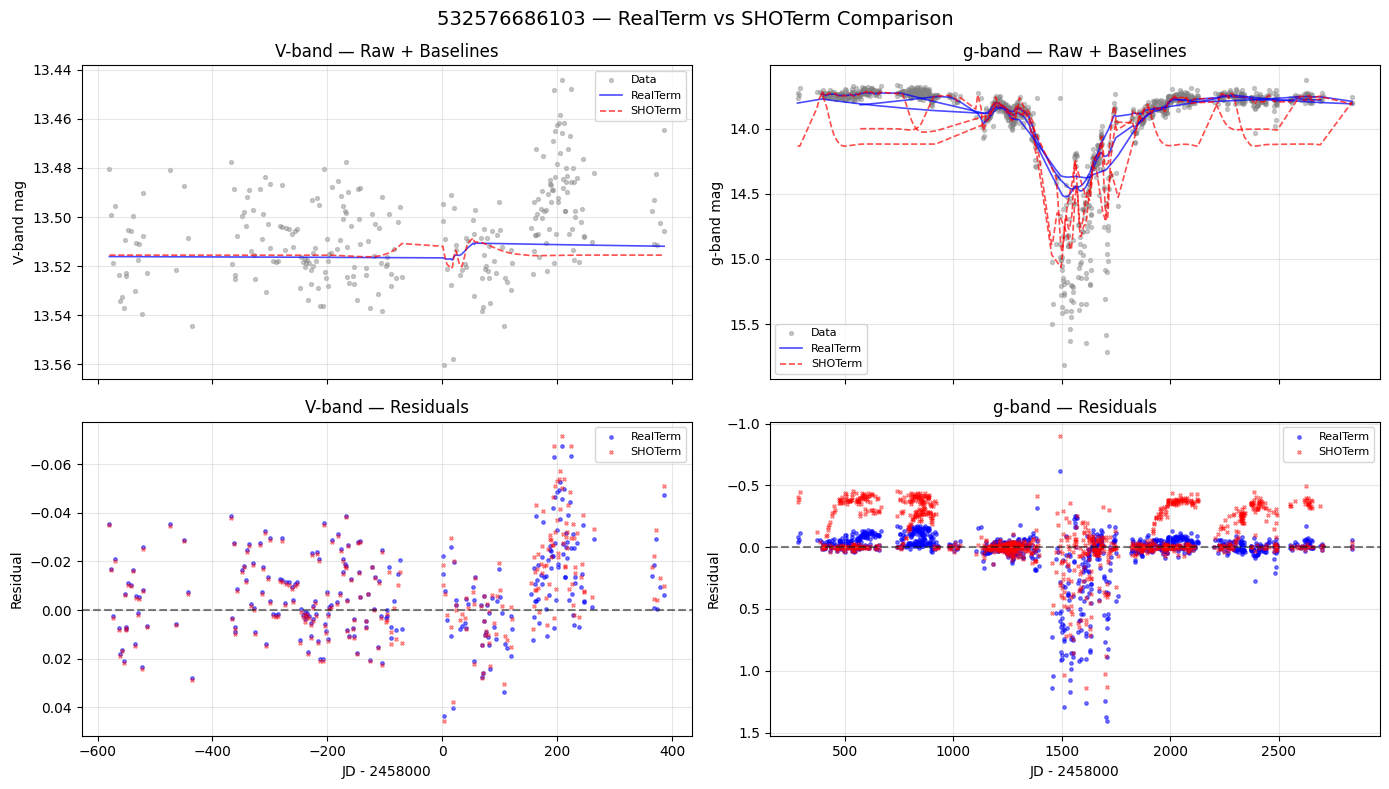

In [10]:
# Compare RealTerm vs SHOTerm kernels
import numpy as np
from celerite2 import GaussianProcess, terms

def gp_baseline_with_kernel(df_band, kernel, dip_sigma_thresh=-1.0, pad_days=100.0, jitter=0.006):
    """Run GP baseline with a custom kernel."""
    t_col, mag_col, err_col, cam_col = "JD", "mag", "error", "camera#"
    
    df_out = df_band.copy()
    for col in ("baseline", "resid", "sigma_resid"):
        if col not in df_out.columns:
            df_out[col] = np.nan
    
    for _, sub in df_out.groupby(cam_col, group_keys=False):
        idx = sub.sort_values(t_col).index
        t = df_out.loc[idx, t_col].to_numpy(float)
        y = df_out.loc[idx, mag_col].to_numpy(float)
        yerr = df_out.loc[idx, err_col].to_numpy(float)
        
        finite = np.isfinite(t) & np.isfinite(y)
        y_med = float(np.nanmedian(y[finite]))
        r0 = y - y_med
        
        r0_f = r0[finite]
        med_r = float(np.nanmedian(r0_f))
        mad_r = 1.4826 * float(np.nanmedian(np.abs(r0_f - med_r)))
        e_med = float(np.nanmedian(yerr[finite & np.isfinite(yerr)])) if np.isfinite(yerr).any() else jitter
        s0 = float(np.sqrt(max(mad_r, 0.0)**2 + max(e_med, 0.0)**2))
        s0 = max(s0, 1e-6)
        
        sig0 = r0 / s0
        dip_flag = finite & np.isfinite(sig0) & (sig0 < dip_sigma_thresh)
        
        keep = finite.copy()
        if dip_flag.any():
            t_dip = t[dip_flag]
            bad = np.zeros_like(keep, dtype=bool)
            for td in t_dip:
                bad |= (np.abs(t - td) <= pad_days)
            keep &= ~bad
        
        if keep.sum() < 10:
            df_out.loc[idx, "baseline"] = y_med
            df_out.loc[idx, "resid"] = y - y_med
            df_out.loc[idx, "sigma_resid"] = (y - y_med) / s0
            continue
        
        t_fit, y_fit = t[keep], y[keep]
        yerr_fit = yerr[keep]
        med = float(np.nanmedian(yerr_fit[np.isfinite(yerr_fit)]))
        yerr_fit = np.where(np.isfinite(yerr_fit), yerr_fit, med)
        yerr_fit = np.nan_to_num(yerr_fit, nan=jitter)
        
        y_mean = float(np.mean(y_fit))
        y_fit0 = y_fit - y_mean
        
        try:
            gp = GaussianProcess(kernel)
            gp.compute(t_fit, diag=yerr_fit**2)
            mu, var = gp.predict(y_fit0, t, return_var=True)
        except Exception as e:
            print(f"GP failed: {e}")
            df_out.loc[idx, "baseline"] = y_med
            df_out.loc[idx, "resid"] = y - y_med
            df_out.loc[idx, "sigma_resid"] = (y - y_med) / s0
            continue
        
        baseline = np.asarray(mu, float) + y_mean
        resid = y - baseline
        var = np.asarray(var, float)
        scale = np.sqrt(np.maximum(var, 0.0) + med**2)
        scale = np.where(np.isfinite(scale) & (scale > 0), scale, max(med, 1e-6))
        
        df_out.loc[idx, "baseline"] = baseline
        df_out.loc[idx, "resid"] = resid
        df_out.loc[idx, "sigma_resid"] = resid / scale
    
    return df_out

def compare_realterm_vs_sho(csv_path, realterm_params, sho_params, mask_params):
    """Compare RealTerm vs SHOTerm kernels on a single light curve."""
    df = read_skypatrol_csv(csv_path)
    source_id = Path(csv_path).stem.replace("-light-curves", "")
    
    # Build kernels
    realterm_kernel = (
        terms.RealTerm(a=realterm_params["a1"], c=1.0/realterm_params["rho1"]) +
        terms.RealTerm(a=realterm_params["a2"], c=1.0/realterm_params["rho2"])
    )
    
    # Use the same SHOTerm parameterization as per_camera_gp_baseline: (sigma, rho, Q)
    sho_kernel = terms.SHOTerm(
        sigma=sho_params["sigma"],
        rho=sho_params["rho"],
        Q=sho_params["Q"],
    )
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex='col')
    fig.suptitle(f"{source_id} — RealTerm vs SHOTerm Comparison", fontsize=14)
    
    for col, (band, band_name) in enumerate([(1, "V-band"), (0, "g-band")]):
        df_band = df[df["v_g_band"] == band].copy()
        if df_band.empty:
            for row in range(2):
                axes[row, col].text(0.5, 0.5, f"No {band_name} data", ha='center', va='center')
            continue
        
        # Run both baselines
        result_real = gp_baseline_with_kernel(df_band.copy(), realterm_kernel, **mask_params)
        result_sho = gp_baseline_with_kernel(df_band.copy(), sho_kernel, **mask_params)
        
        jd = result_real["JD"].values - 2458000
        mag = result_real["mag"].values
        
        # Plot raw + baselines
        ax_top = axes[0, col]
        ax_top.scatter(jd, mag, s=8, alpha=0.4, c='gray', label='Data')

        # Plot per-camera baselines to avoid artificial "combs" from duplicate timestamps
        # and to avoid incorrectly connecting baselines across camera groups.
        cams_here = sorted(result_real["camera#"].dropna().unique())
        for i_cam, cam in enumerate(cams_here):
            r_cam = result_real[result_real["camera#"] == cam][["JD", "baseline"]].dropna().copy()
            s_cam = result_sho[result_sho["camera#"] == cam][["JD", "baseline"]].dropna().copy()

            if not r_cam.empty:
                r_cam["JD_plot"] = r_cam["JD"].values - 2458000
                r_cam = r_cam.sort_values("JD_plot")
                if r_cam["JD_plot"].duplicated().any():
                    r_cam = r_cam.groupby("JD_plot", as_index=False)["baseline"].median()
                ax_top.plot(
                    r_cam["JD_plot"],
                    r_cam["baseline"],
                    '-',
                    color='blue',
                    lw=1.2,
                    alpha=0.7,
                    label='RealTerm' if i_cam == 0 else None,
                )

            if not s_cam.empty:
                s_cam["JD_plot"] = s_cam["JD"].values - 2458000
                s_cam = s_cam.sort_values("JD_plot")
                if s_cam["JD_plot"].duplicated().any():
                    s_cam = s_cam.groupby("JD_plot", as_index=False)["baseline"].median()
                ax_top.plot(
                    s_cam["JD_plot"],
                    s_cam["baseline"],
                    '--',
                    color='red',
                    lw=1.2,
                    alpha=0.7,
                    label='SHOTerm' if i_cam == 0 else None,
                )

        ax_top.invert_yaxis()
        ax_top.set_ylabel(f"{band_name} mag")
        ax_top.set_title(f"{band_name} — Raw + Baselines")
        ax_top.legend(loc='best', fontsize=8)
        ax_top.grid(True, alpha=0.3)
        
        # Plot residuals
        ax_bot = axes[1, col]
        ax_bot.scatter(jd, result_real["resid"].values, s=6, alpha=0.5, c='blue', marker='o', label='RealTerm')
        ax_bot.scatter(jd, result_sho["resid"].values, s=6, alpha=0.5, c='red', marker='x', label='SHOTerm')
        ax_bot.axhline(0, color='k', linestyle='--', alpha=0.5)
        ax_bot.invert_yaxis()
        ax_bot.set_ylabel("Residual")
        ax_bot.set_xlabel("JD - 2458000")
        ax_bot.set_title(f"{band_name} — Residuals")
        ax_bot.legend(loc='best', fontsize=8)
        ax_bot.grid(True, alpha=0.3)
        
        # Stats
        n_real = (result_real["sigma_resid"] < -3).sum()
        n_sho = (result_sho["sigma_resid"] < -3).sum()
        print(f"{source_id} {band_name}: RealTerm {n_real} dips, SHOTerm {n_sho} dips")
    
    plt.tight_layout()
    plt.show()
    return fig

# Current RealTerm parameters
realterm_params = {
    "a1": 0.02**2,  # 0.0004
    "rho1": 1000.0,
    "a2": 0.01**2,  # 0.0001
    "rho2": 3000.0,
}

# SHOTerm parameters in the same parameterization as per_camera_gp_baseline
# (sigma [mag], rho [days], Q). Pull from gp_kwargs if present so comparisons are consistent.
if "gp_kwargs" in globals():
    sho_params = {
        "sigma": float(gp_kwargs.get("sigma", 0.08)),
        "rho": float(gp_kwargs.get("rho", 150.0)),
        "Q": float(gp_kwargs.get("q", 0.7)),
    }
else:
    sho_params = {
        "sigma": 0.08,
        "rho": 150.0,
        "Q": 0.7,
    }

# Masking parameters
mask_params = {
    "dip_sigma_thresh": -1.0,
    "pad_days": 100.0,
    "jitter": 0.006,
}

print("=" * 70)
print("RealTerm params:", realterm_params)
print("SHOTerm params:", sho_params)
print("Masking:", mask_params)
print("=" * 70)

# Test on ALL sources
for src in test_sources:
    compare_realterm_vs_sho(src, realterm_params, sho_params, mask_params)


GP kwargs: {'S0': 0.0005, 'w0': 0.0031415926535897933, 'q': 0.7, 'jitter': 0.006}
Trend kwargs: {'days_short': 200.0, 'days_long': 800.0, 'min_points': 12, 'last_window_guard': 120.0}
60130040391 V-band: GP(SHO) 71 dips, Trend 3 dips
60130040391 g-band: GP(SHO) 247 dips, Trend 20 dips


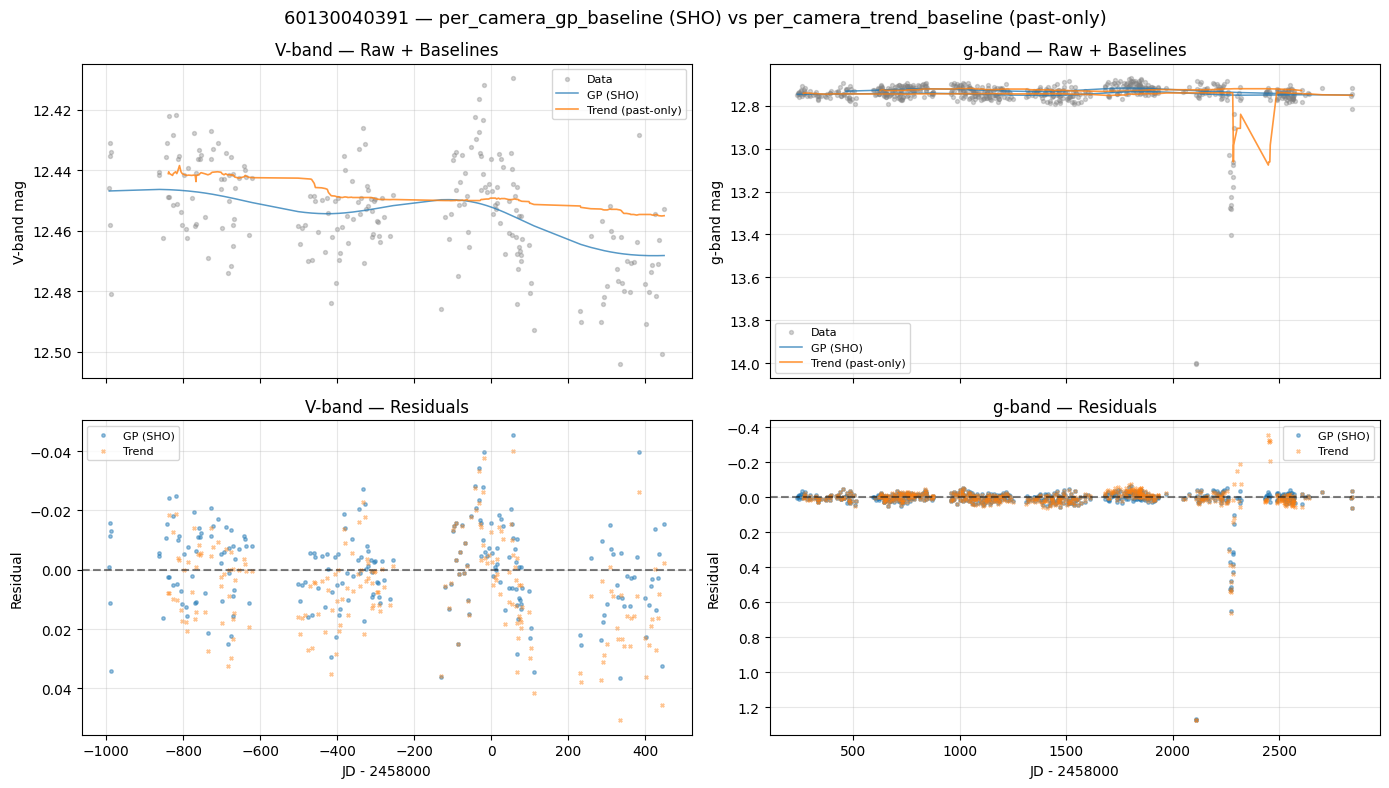

68720274411 V-band: GP(SHO) 109 dips, Trend 16 dips
68720274411 g-band: GP(SHO) 311 dips, Trend 51 dips


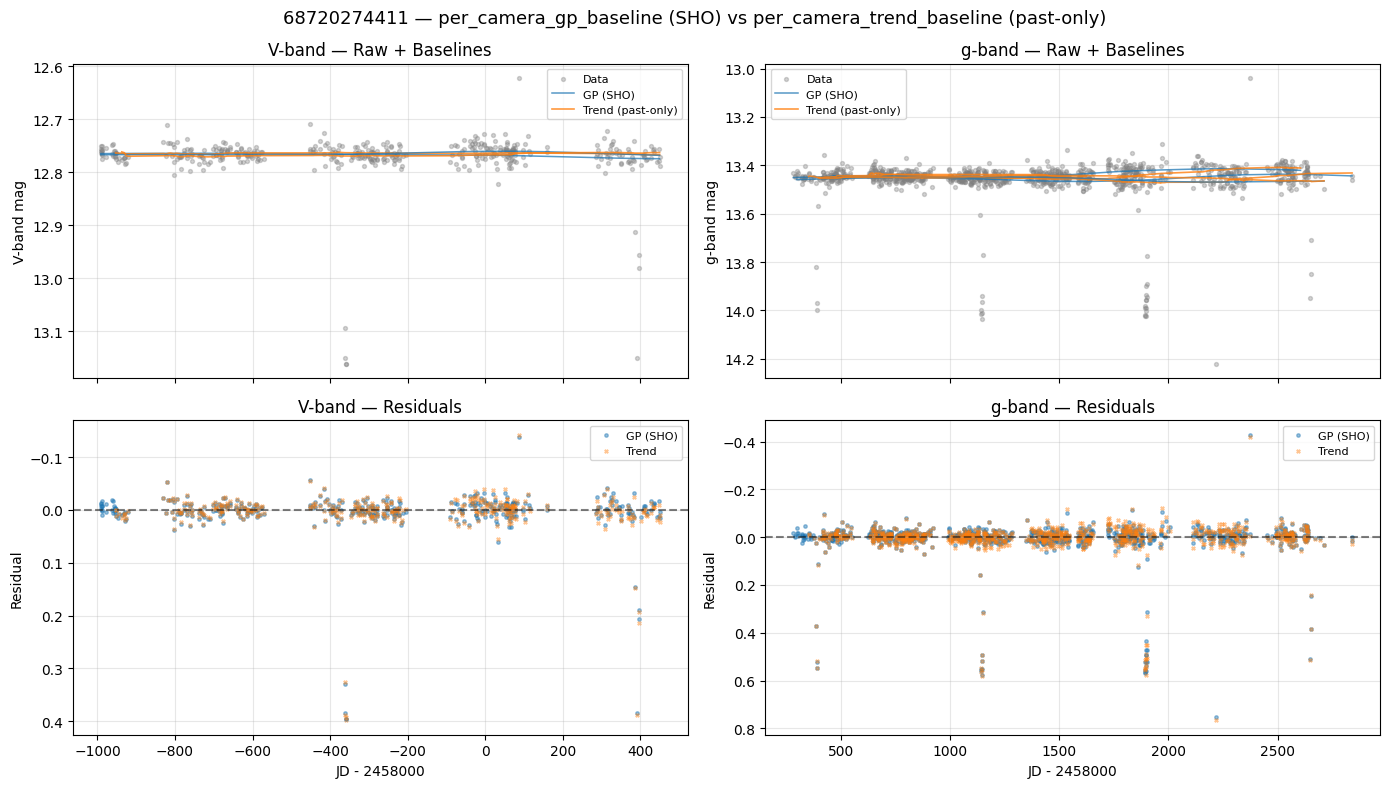

120259184943 V-band: GP(SHO) 200 dips, Trend 14 dips
120259184943 g-band: GP(SHO) 511 dips, Trend 33 dips


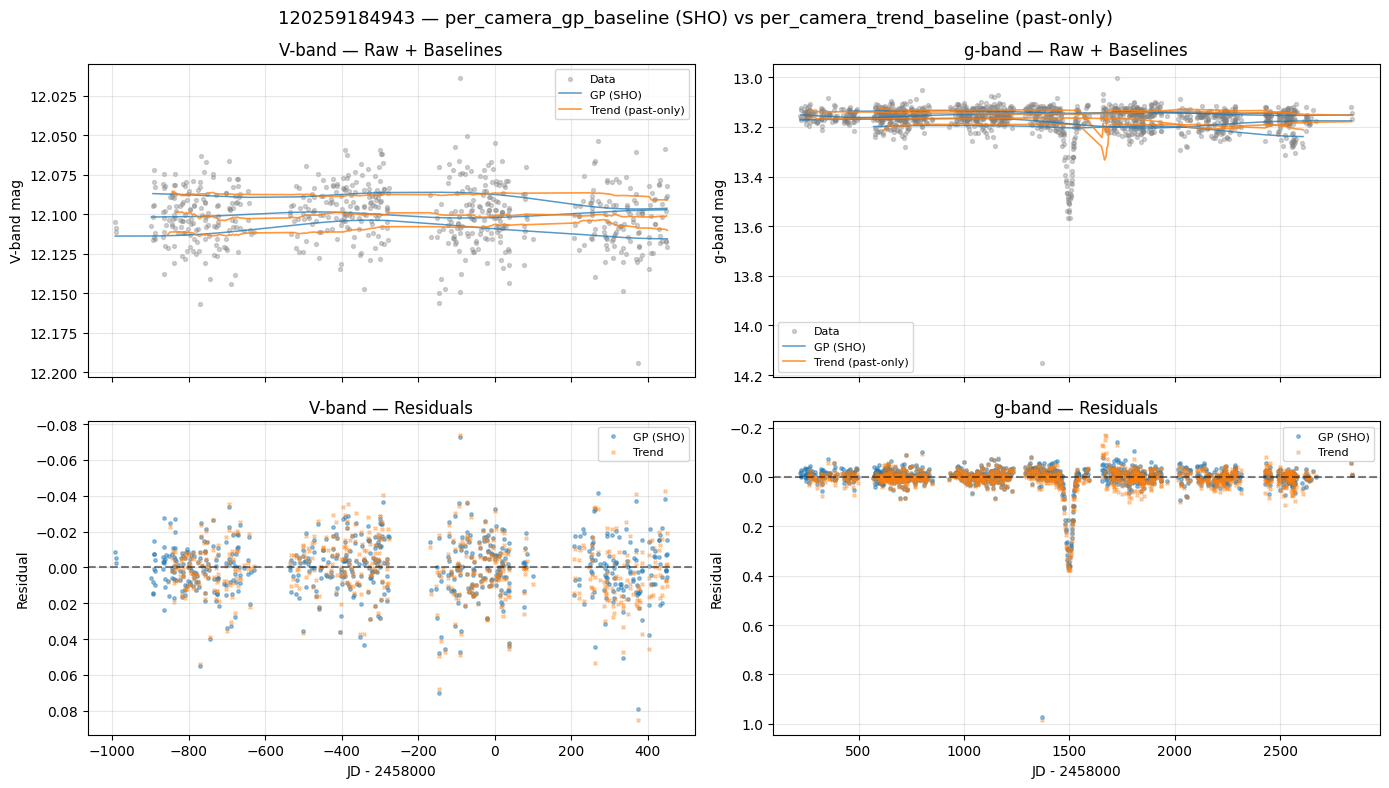

223339338105 V-band: GP(SHO) 167 dips, Trend 8 dips
223339338105 g-band: GP(SHO) 565 dips, Trend 27 dips


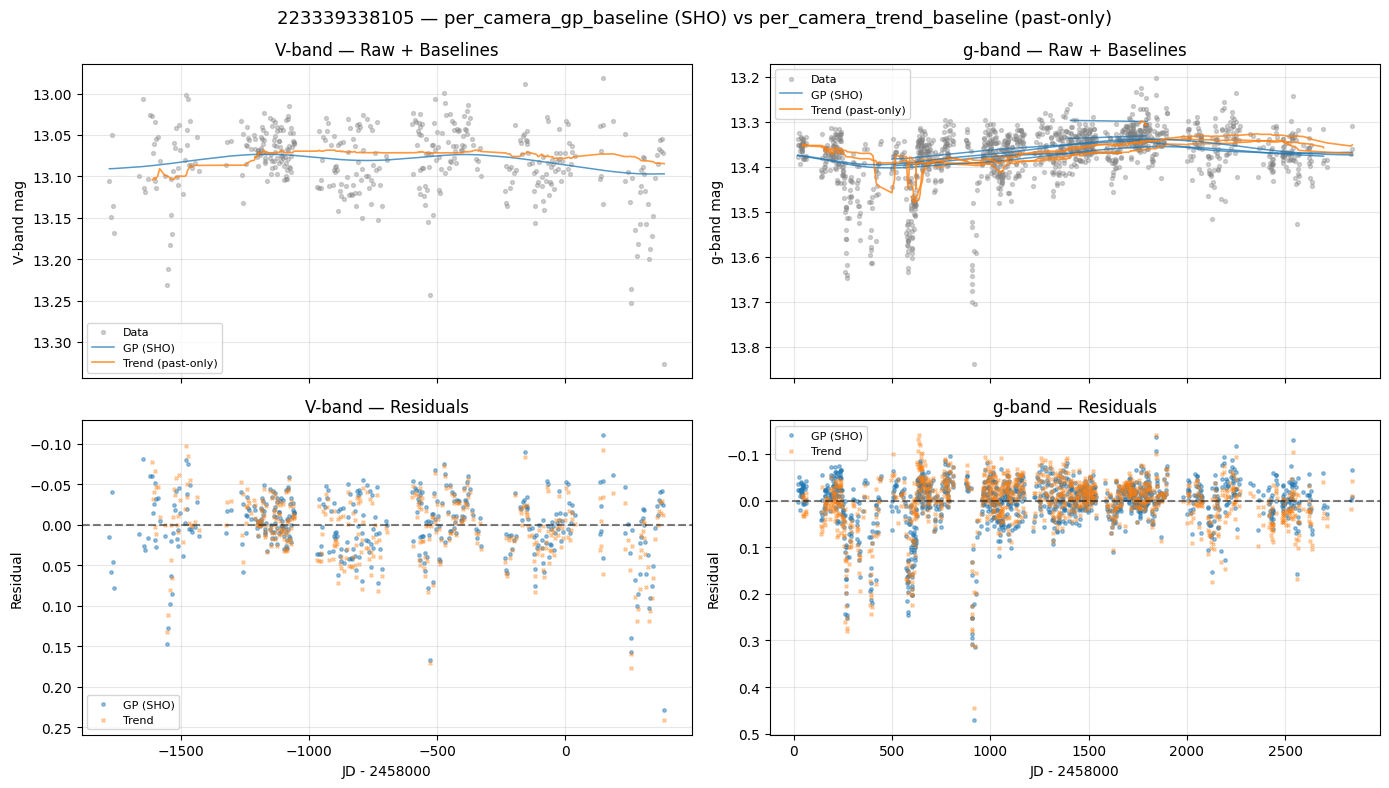

377957522430 V-band: GP(SHO) 150 dips, Trend 10 dips
377957522430 g-band: GP(SHO) 499 dips, Trend 89 dips


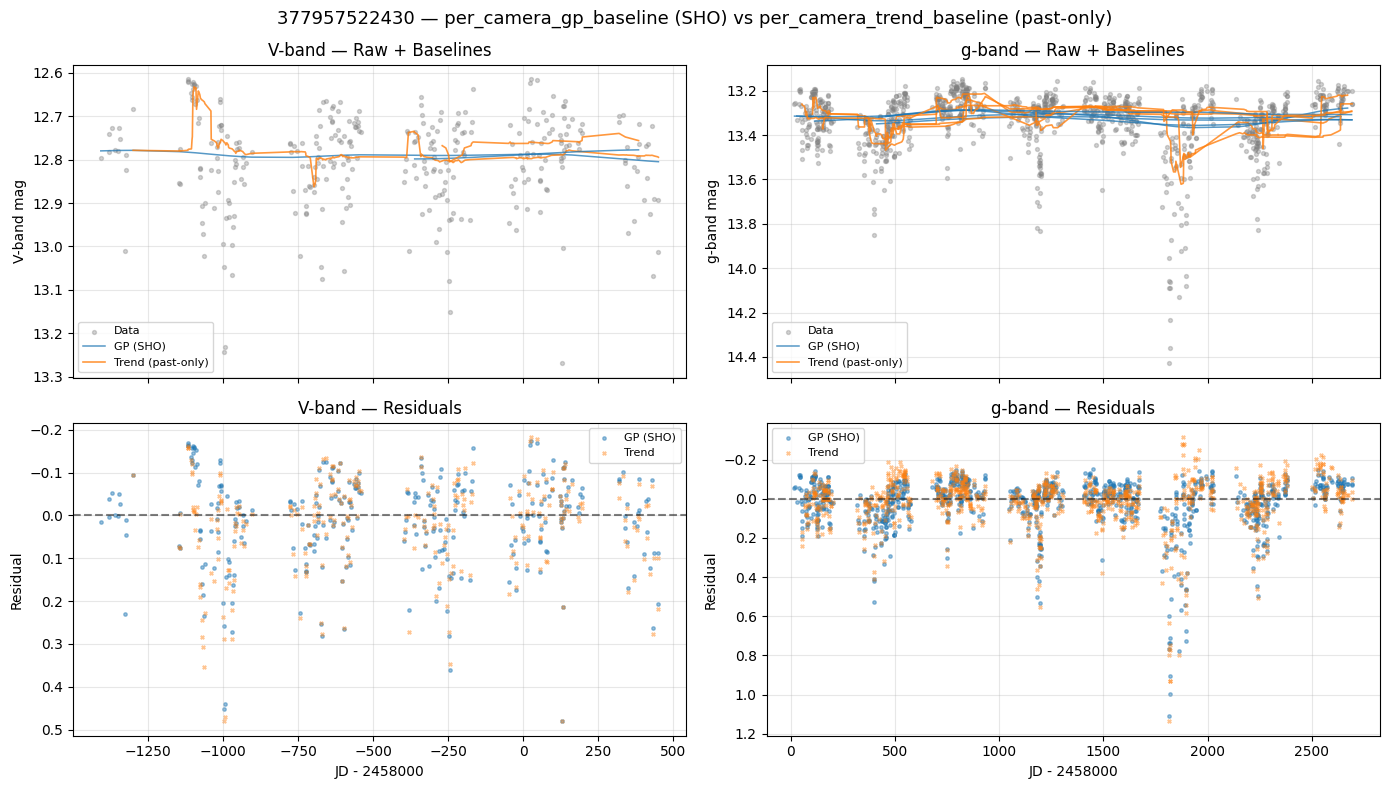

438086977939 V-band: GP(SHO) 98 dips, Trend 5 dips
438086977939 g-band: GP(SHO) 361 dips, Trend 57 dips


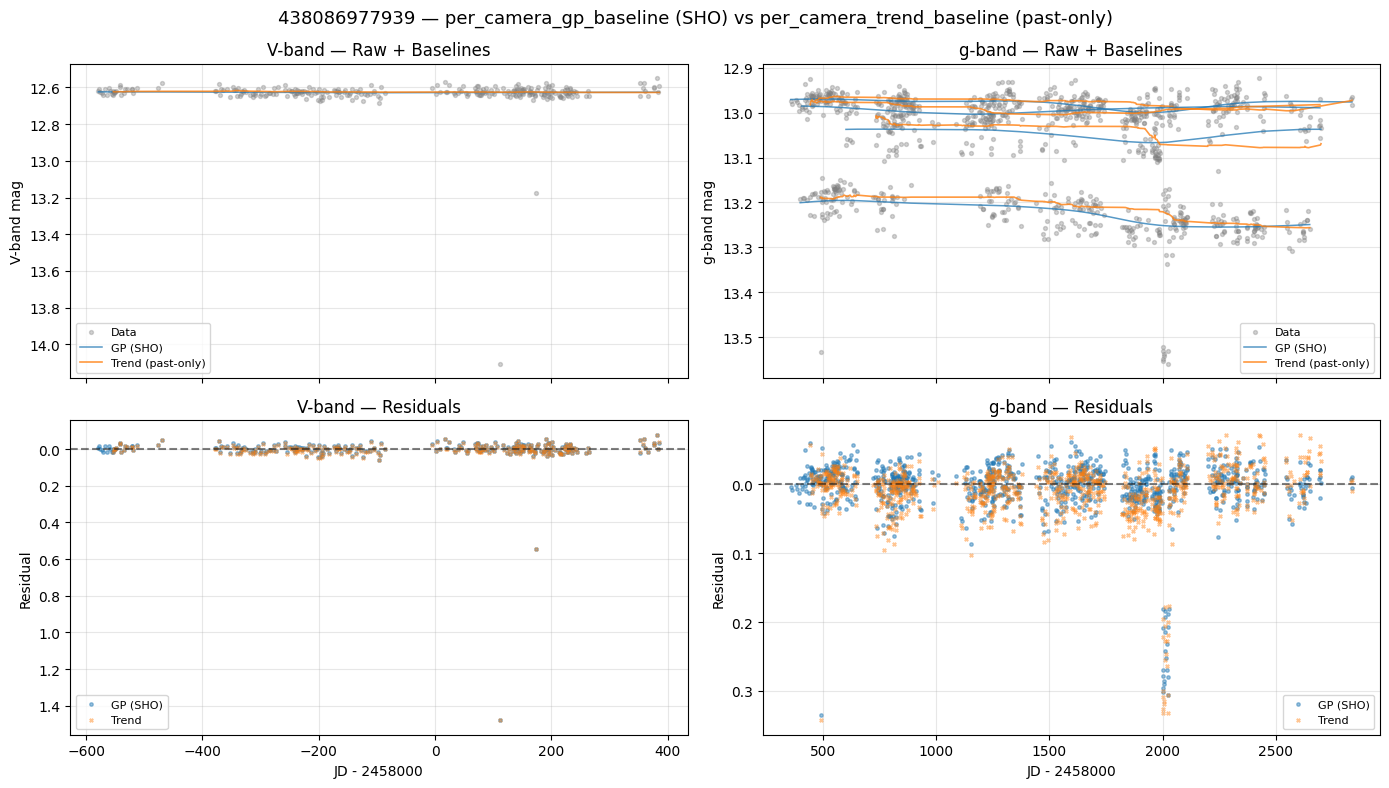

472447294641 V-band: GP(SHO) 148 dips, Trend 7 dips
472447294641 g-band: GP(SHO) 496 dips, Trend 36 dips


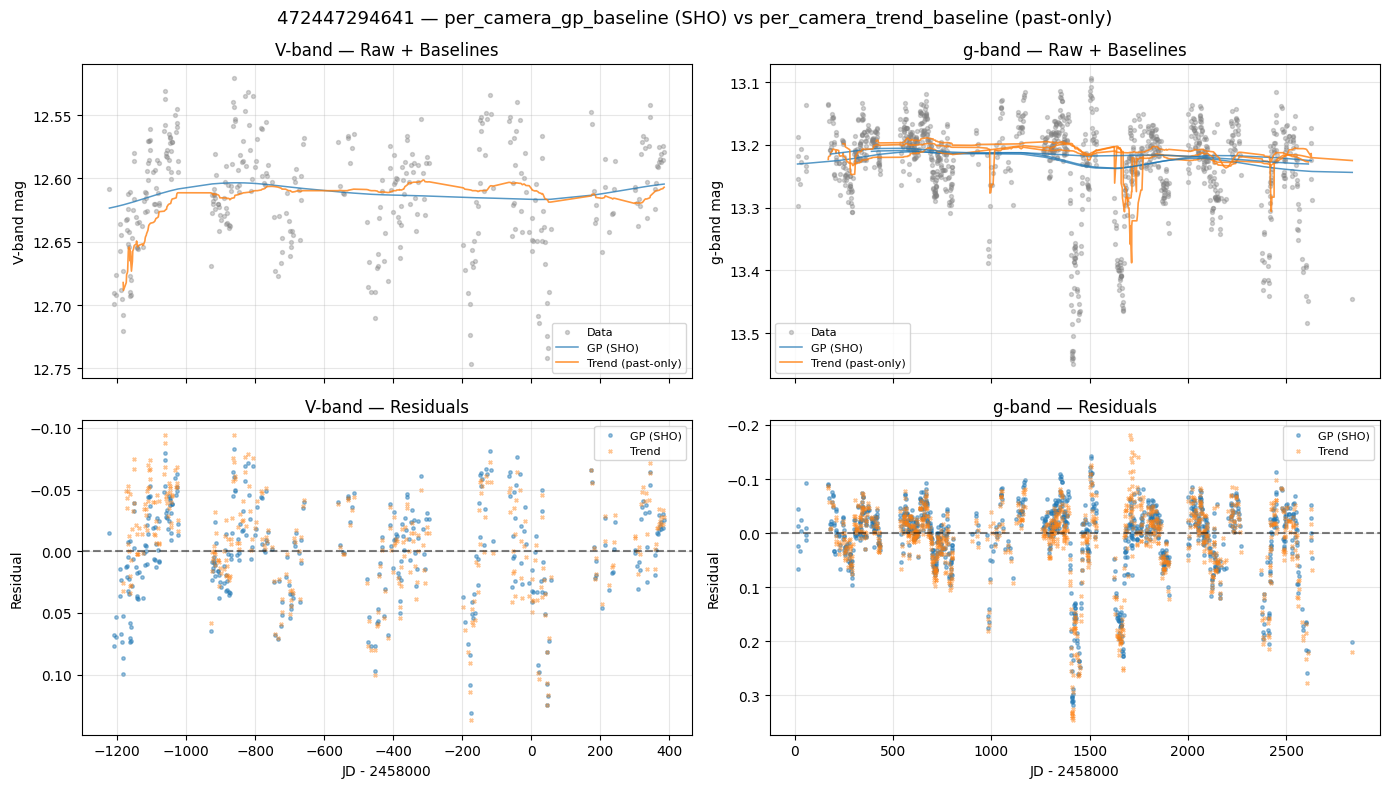

515396514761 V-band: GP(SHO) 68 dips, Trend 21 dips
515396514761 g-band: GP(SHO) 534 dips, Trend 143 dips


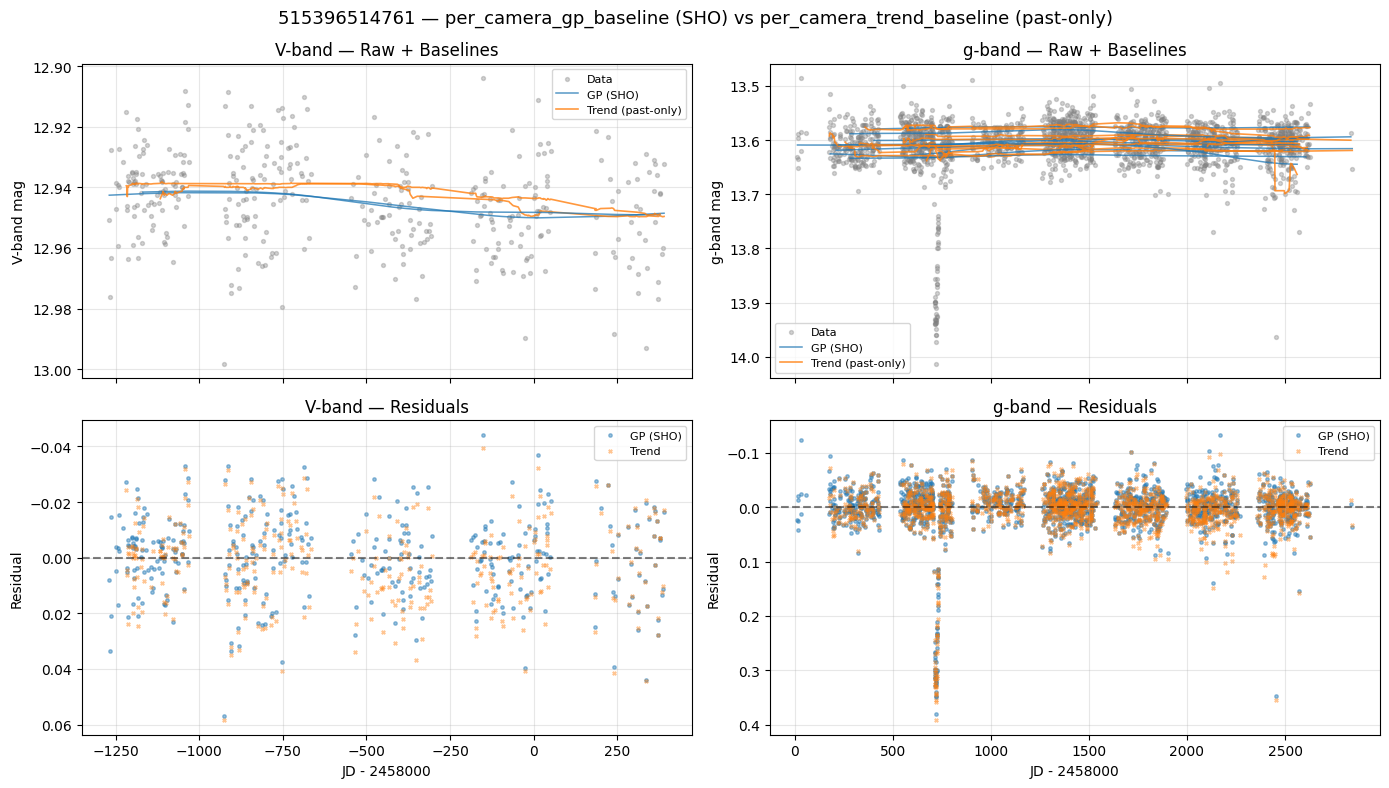

532576686103 V-band: GP(SHO) 48 dips, Trend 7 dips
532576686103 g-band: GP(SHO) 632 dips, Trend 30 dips


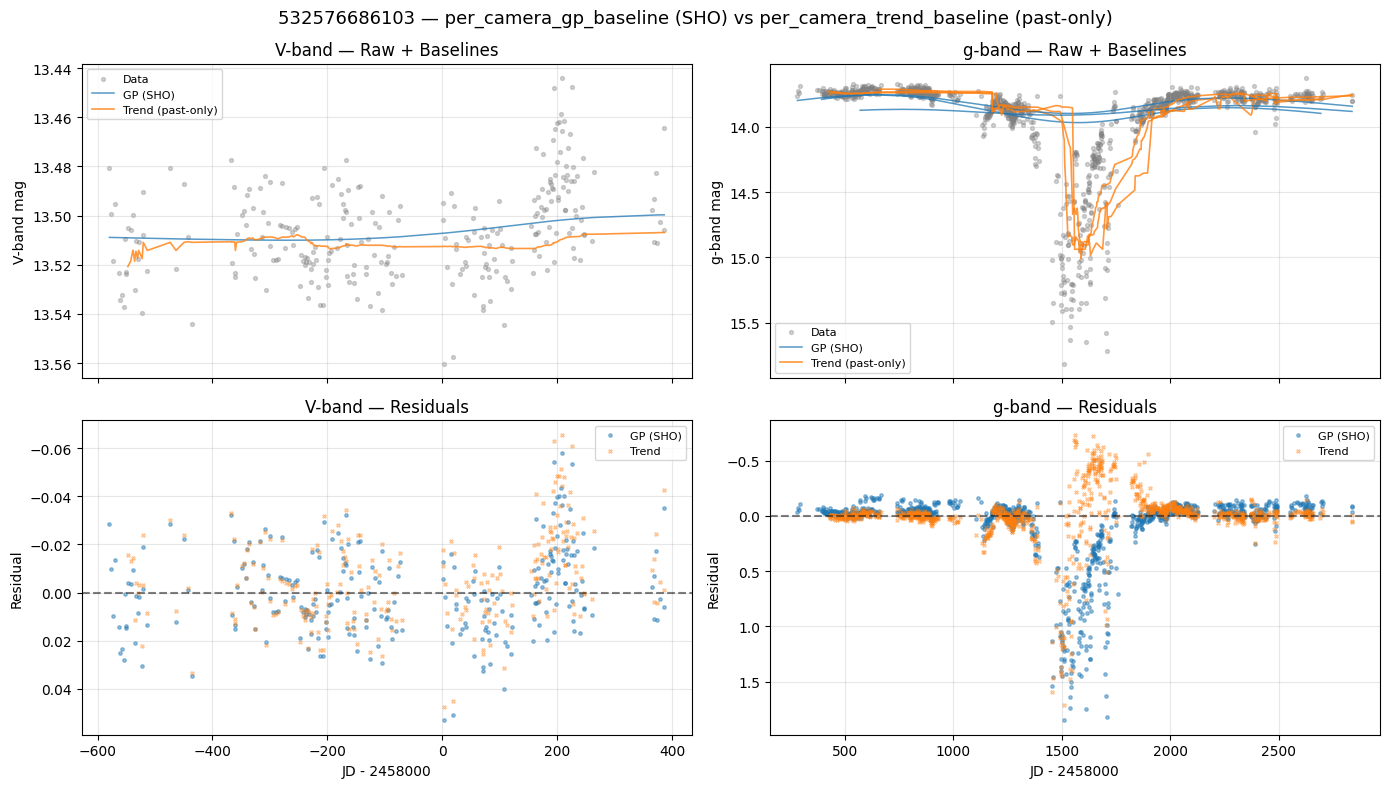

In [11]:
# Compare (A) current per-camera GP baseline vs (B) robust past-only trend baseline
# Goal: dip detection without future leakage.

import numpy as np
import matplotlib.pyplot as plt

from df_plot import read_skypatrol_csv
from lc_baseline import per_camera_gp_baseline, per_camera_trend_baseline


def compare_gp_vs_trend(csv_path, gp_kwargs=None, trend_kwargs=None):
    gp_kwargs = gp_kwargs or {"S0": 0.0005, "w0": 0.0031415926535897933, "q": 0.7, "jitter": 0.006}
    trend_kwargs = trend_kwargs or {
        "days_short": 200.0,
        "days_long": 800.0,
        "min_points": 12,
        "last_window_guard": 120.0,
    }

    df = read_skypatrol_csv(csv_path)
    source_id = Path(csv_path).stem.replace("-light-curves", "")

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex="col")
    fig.suptitle(f"{source_id} — per_camera_gp_baseline (SHO) vs per_camera_trend_baseline (past-only)", fontsize=13)

    for col, (band, band_name) in enumerate([(1, "V-band"), (0, "g-band")]):
        df_band = df[df["v_g_band"] == band].copy()
        if df_band.empty:
            for row in range(2):
                axes[row, col].text(0.5, 0.5, f"No {band_name} data", ha="center", va="center")
            continue

        res_gp = per_camera_gp_baseline(df_band.copy(), **gp_kwargs)
        res_tr = per_camera_trend_baseline(df_band.copy(), **trend_kwargs)

        jd = res_gp["JD"].values - 2458000
        mag = res_gp["mag"].values

        ax_top = axes[0, col]
        ax_top.scatter(jd, mag, s=8, alpha=0.35, c="gray", label="Data")

        # Plot per-camera baseline segments (sorted, duplicates collapsed) to avoid plot artifacts
        cams_here = sorted(res_gp["camera#"].dropna().unique())
        for i_cam, cam in enumerate(cams_here):
            gp_cam = res_gp[res_gp["camera#"] == cam][["JD", "baseline"]].dropna().copy()
            tr_cam = res_tr[res_tr["camera#"] == cam][["JD", "baseline"]].dropna().copy()

            if not gp_cam.empty:
                gp_cam["JD_plot"] = gp_cam["JD"].values - 2458000
                gp_cam = gp_cam.sort_values("JD_plot")
                if gp_cam["JD_plot"].duplicated().any():
                    gp_cam = gp_cam.groupby("JD_plot", as_index=False)["baseline"].median()
                ax_top.plot(
                    gp_cam["JD_plot"],
                    gp_cam["baseline"],
                    color="tab:blue",
                    lw=1.1,
                    alpha=0.75,
                    label="GP (SHO)" if i_cam == 0 else None,
                )

            if not tr_cam.empty:
                tr_cam["JD_plot"] = tr_cam["JD"].values - 2458000
                tr_cam = tr_cam.sort_values("JD_plot")
                if tr_cam["JD_plot"].duplicated().any():
                    tr_cam = tr_cam.groupby("JD_plot", as_index=False)["baseline"].median()
                ax_top.plot(
                    tr_cam["JD_plot"],
                    tr_cam["baseline"],
                    color="tab:orange",
                    lw=1.2,
                    alpha=0.8,
                    label="Trend (past-only)" if i_cam == 0 else None,
                )

        ax_top.invert_yaxis()
        ax_top.set_ylabel(f"{band_name} mag")
        ax_top.set_title(f"{band_name} — Raw + Baselines")
        ax_top.grid(True, alpha=0.3)
        ax_top.legend(loc="best", fontsize=8)

        ax_bot = axes[1, col]
        ax_bot.scatter(jd, res_gp["resid"].values, s=6, alpha=0.45, c="tab:blue", marker="o", label="GP (SHO)")
        ax_bot.scatter(jd, res_tr["resid"].values, s=6, alpha=0.45, c="tab:orange", marker="x", label="Trend")
        ax_bot.axhline(0, color="k", linestyle="--", alpha=0.5)
        ax_bot.invert_yaxis()
        ax_bot.set_ylabel("Residual")
        ax_bot.set_xlabel("JD - 2458000")
        ax_bot.set_title(f"{band_name} — Residuals")
        ax_bot.grid(True, alpha=0.3)
        ax_bot.legend(loc="best", fontsize=8)

        n_gp = int((res_gp["sigma_resid"] < -3).sum())
        n_tr = int((res_tr["sigma_resid"] < -3).sum())
        print(f"{source_id} {band_name}: GP(SHO) {n_gp} dips, Trend {n_tr} dips")

    plt.tight_layout()
    plt.show()
    return fig


# Run on the same sources as above
# GP Kwargs 1 - do work: Using S0, w0, Q parameterization
_gp_kwargs = {
    "S0": 0.0005,
    "w0": 0.0031415926535897933,
    "q": 0.7,
    "jitter": 0.006,
}
_trend_kwargs = {
    "days_short": 200.0,
    "days_long": 800.0,
    "min_points": 12,
    "last_window_guard": 120.0,
}

print("GP kwargs:", _gp_kwargs)
print("Trend kwargs:", _trend_kwargs)

for src in test_sources:
    compare_gp_vs_trend(src, gp_kwargs=_gp_kwargs, trend_kwargs=_trend_kwargs)



SHO kernel params: {'S0': 0.0005, 'w0': 0.0031415926535897933, 'Q': 0.7}
Mask params: {'dip_sigma_thresh': -1.0, 'pad_days': 100.0, 'jitter': 0.006}
60130040391 V-band: SHOTerm 0 dips, OU-mixture 0 dips
60130040391 g-band: SHOTerm 348 dips, OU-mixture 135 dips


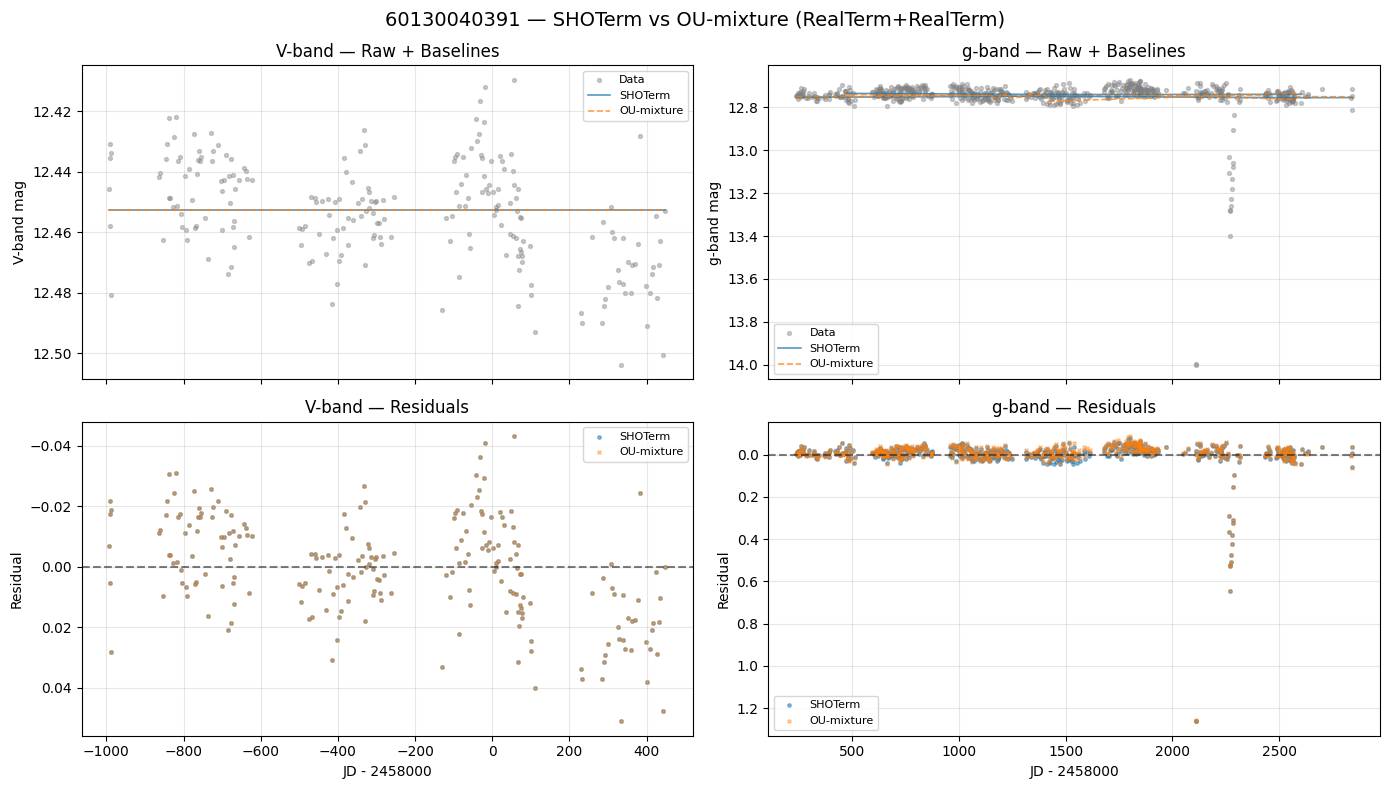

68720274411 V-band: SHOTerm 4 dips, OU-mixture 4 dips
68720274411 g-band: SHOTerm 472 dips, OU-mixture 88 dips


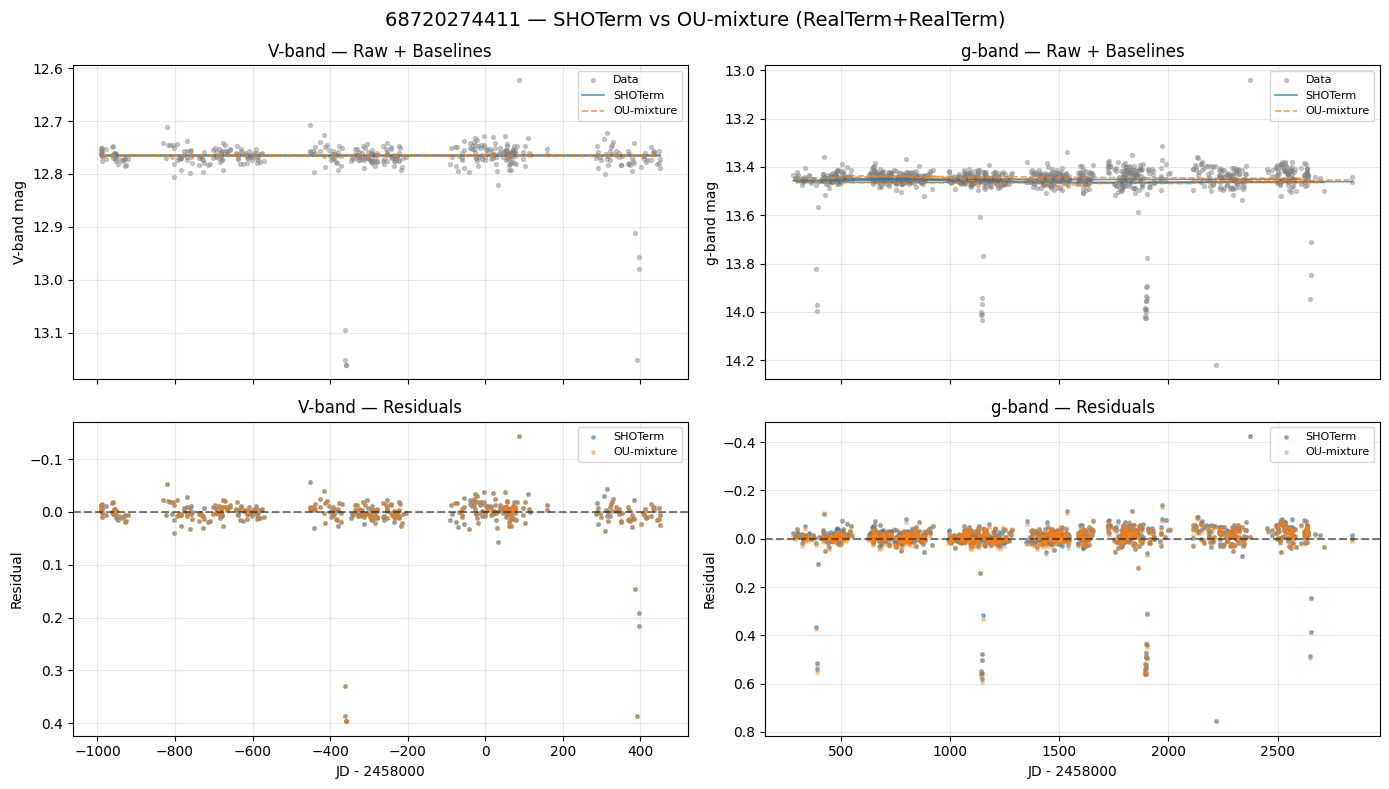

120259184943 V-band: SHOTerm 126 dips, OU-mixture 10 dips
120259184943 g-band: SHOTerm 826 dips, OU-mixture 362 dips


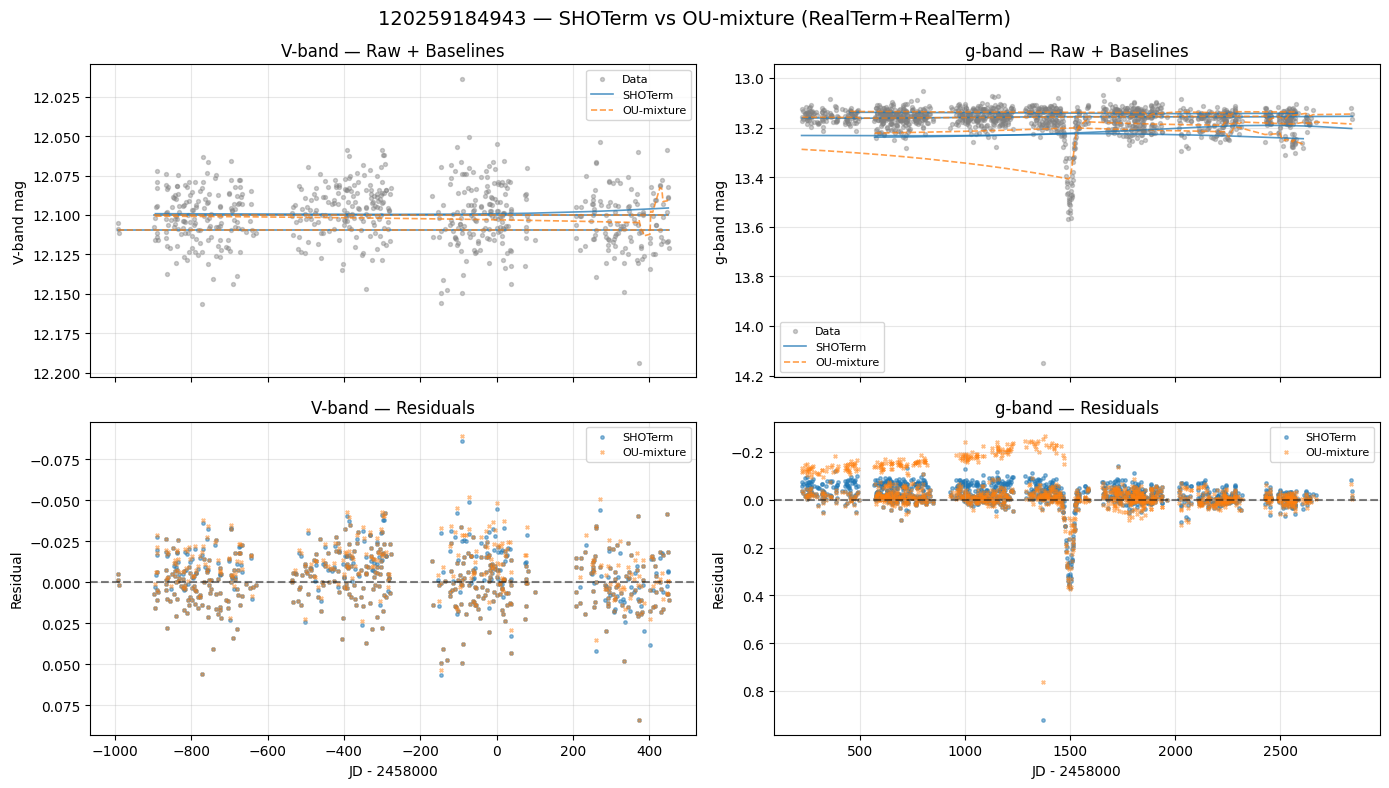

223339338105 V-band: SHOTerm 320 dips, OU-mixture 214 dips
223339338105 g-band: SHOTerm 924 dips, OU-mixture 570 dips


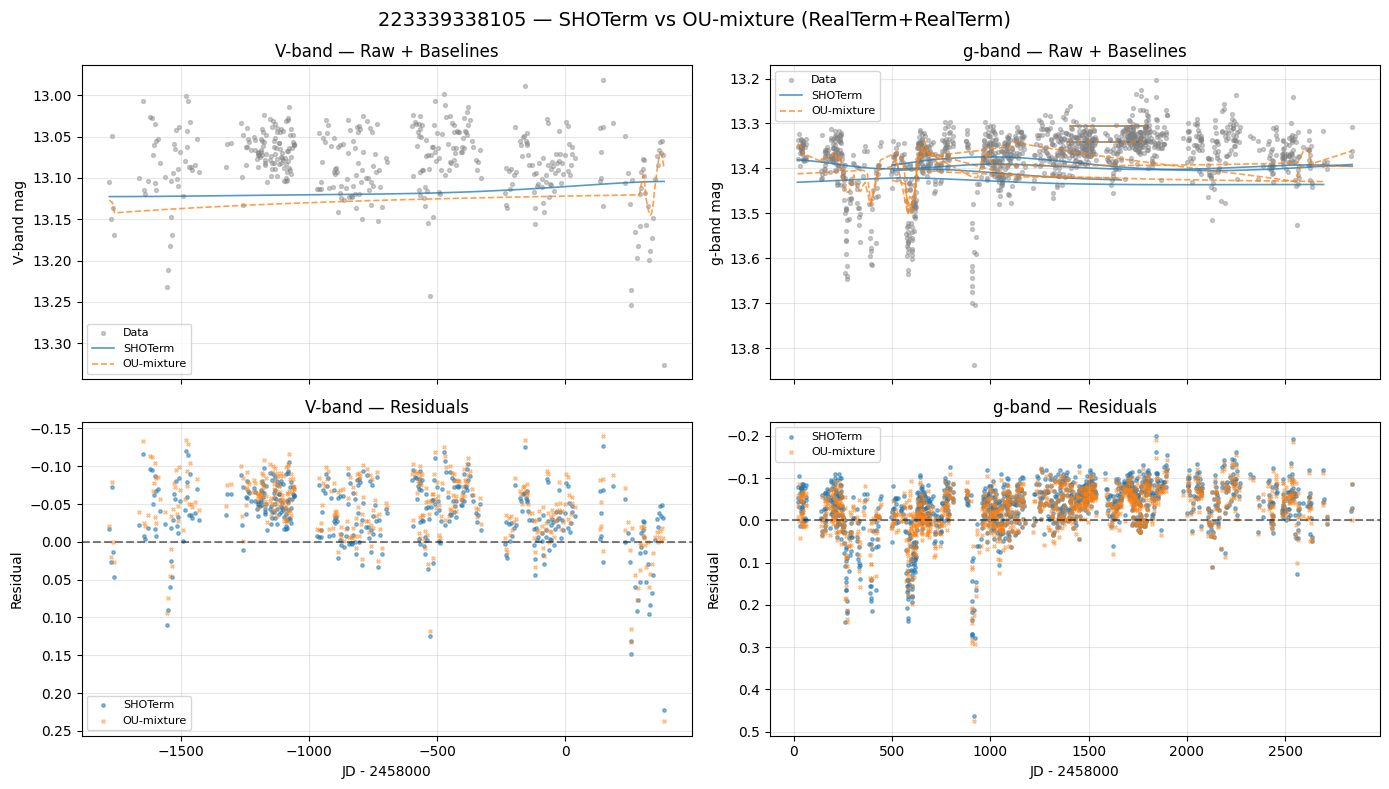

377957522430 V-band: SHOTerm 26 dips, OU-mixture 23 dips
377957522430 g-band: SHOTerm 657 dips, OU-mixture 538 dips


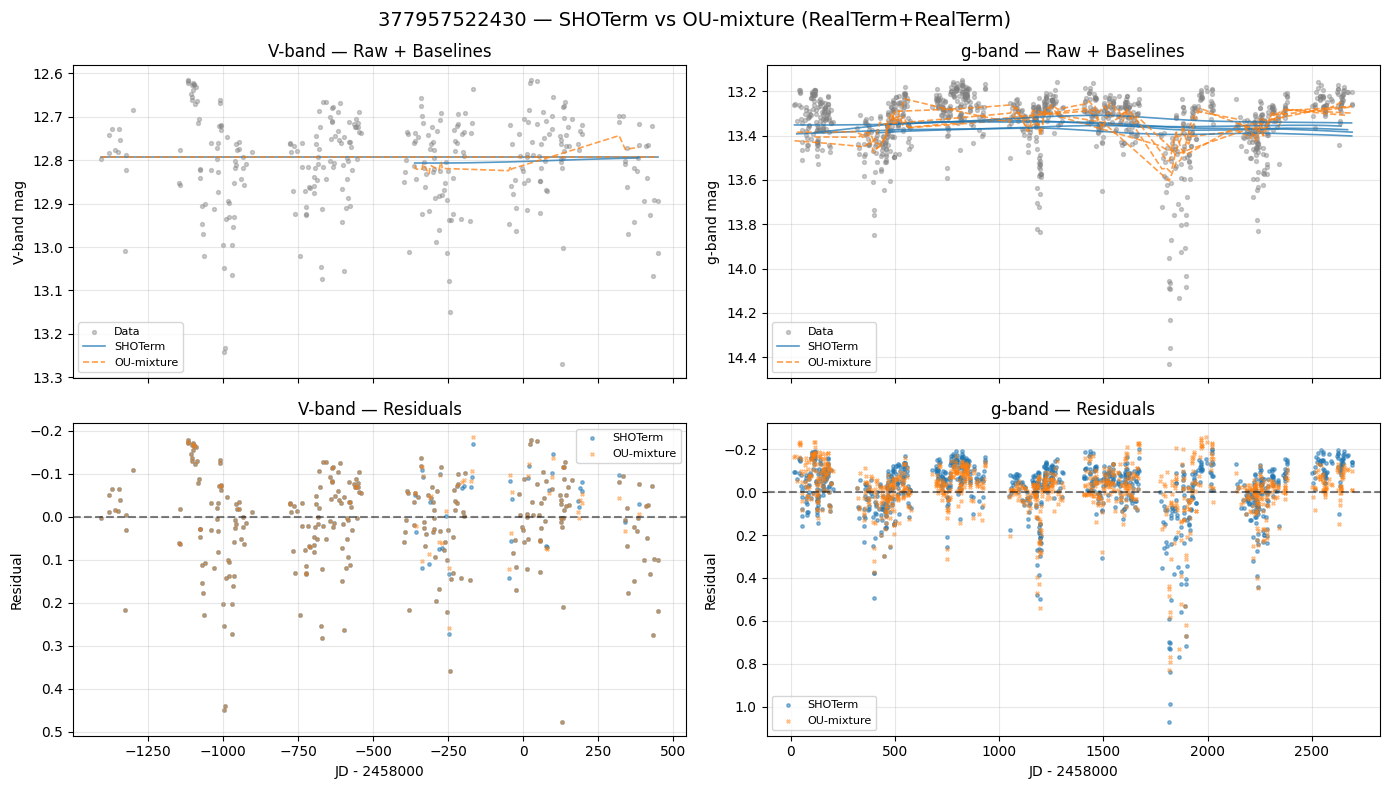

438086977939 V-band: SHOTerm 1 dips, OU-mixture 1 dips
438086977939 g-band: SHOTerm 664 dips, OU-mixture 256 dips


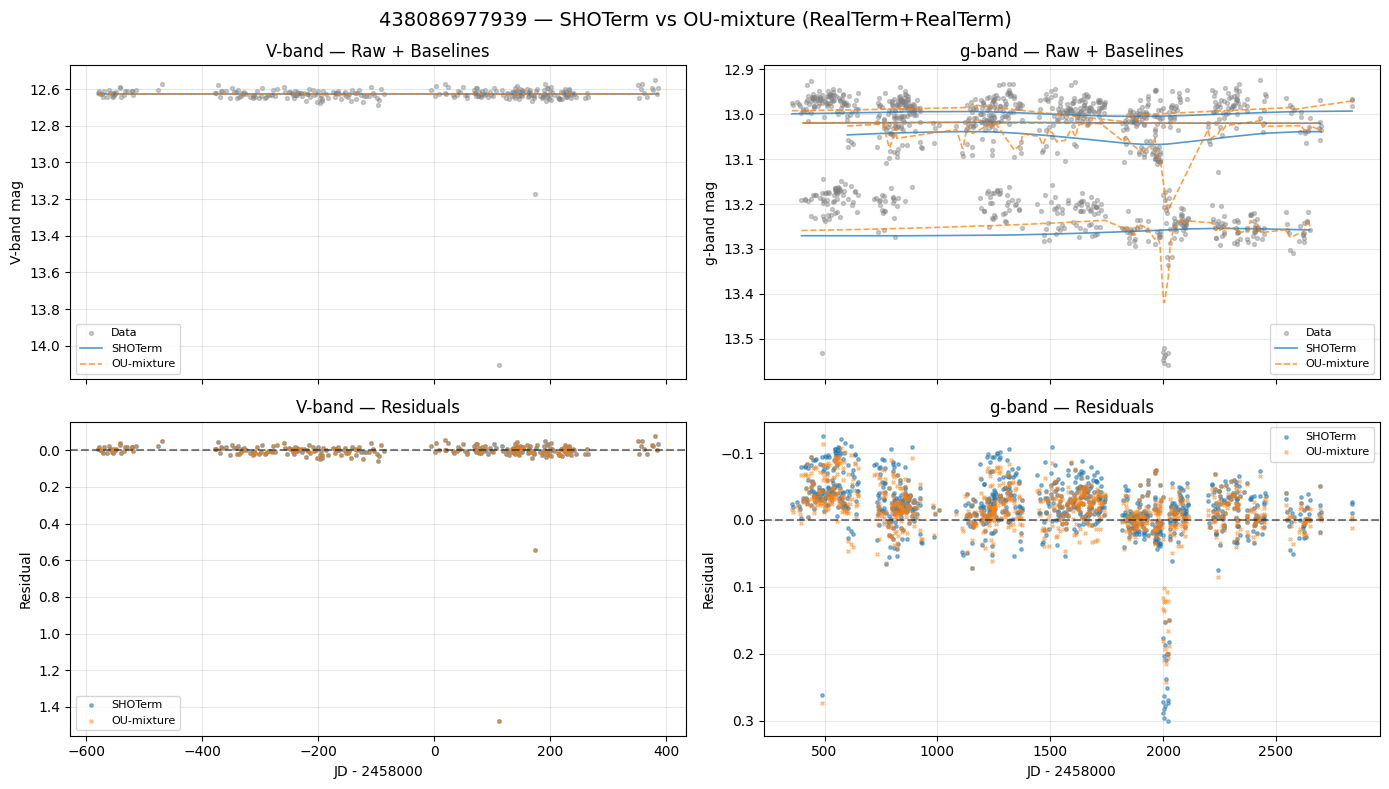

472447294641 V-band: SHOTerm 0 dips, OU-mixture 0 dips
472447294641 g-band: SHOTerm 768 dips, OU-mixture 603 dips


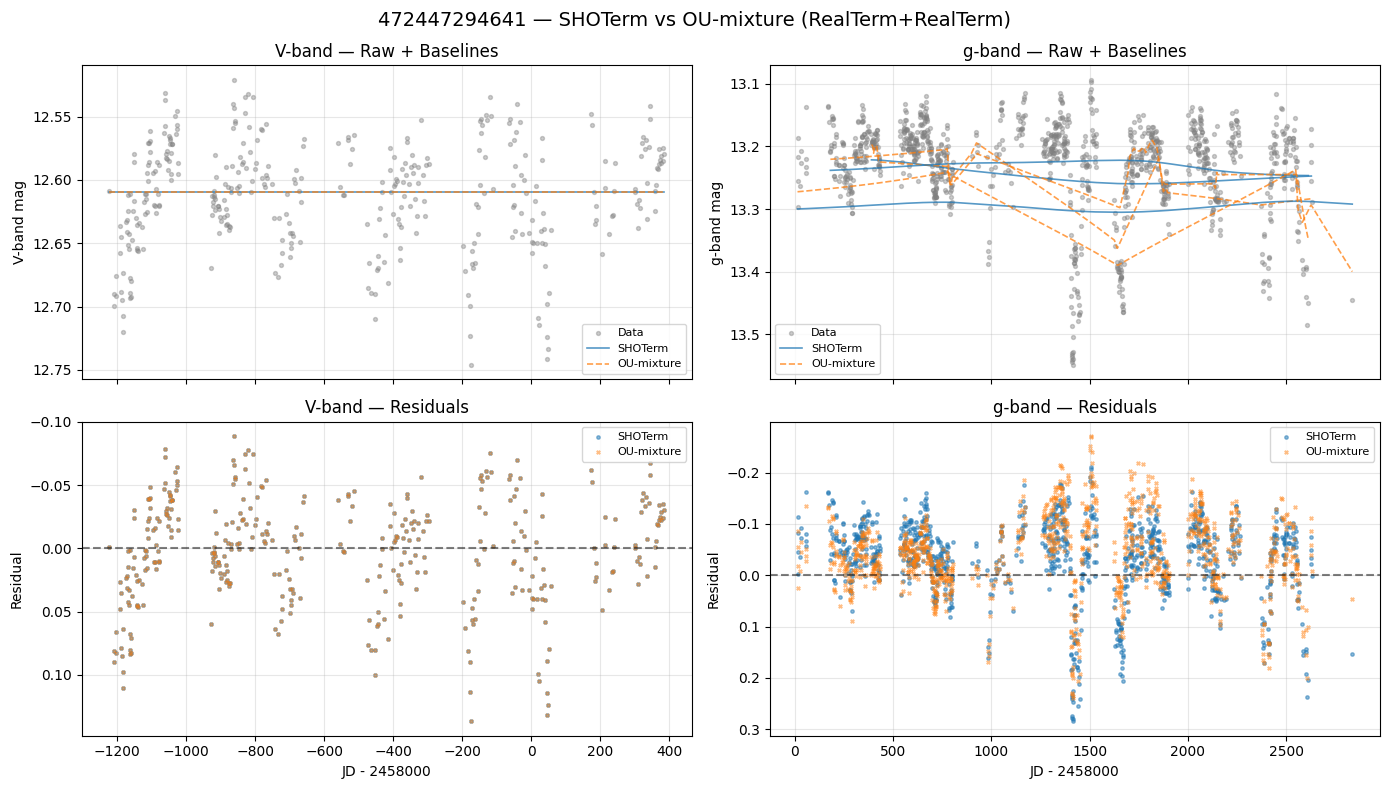

515396514761 V-band: SHOTerm 115 dips, OU-mixture 3 dips
515396514761 g-band: SHOTerm 550 dips, OU-mixture 130 dips


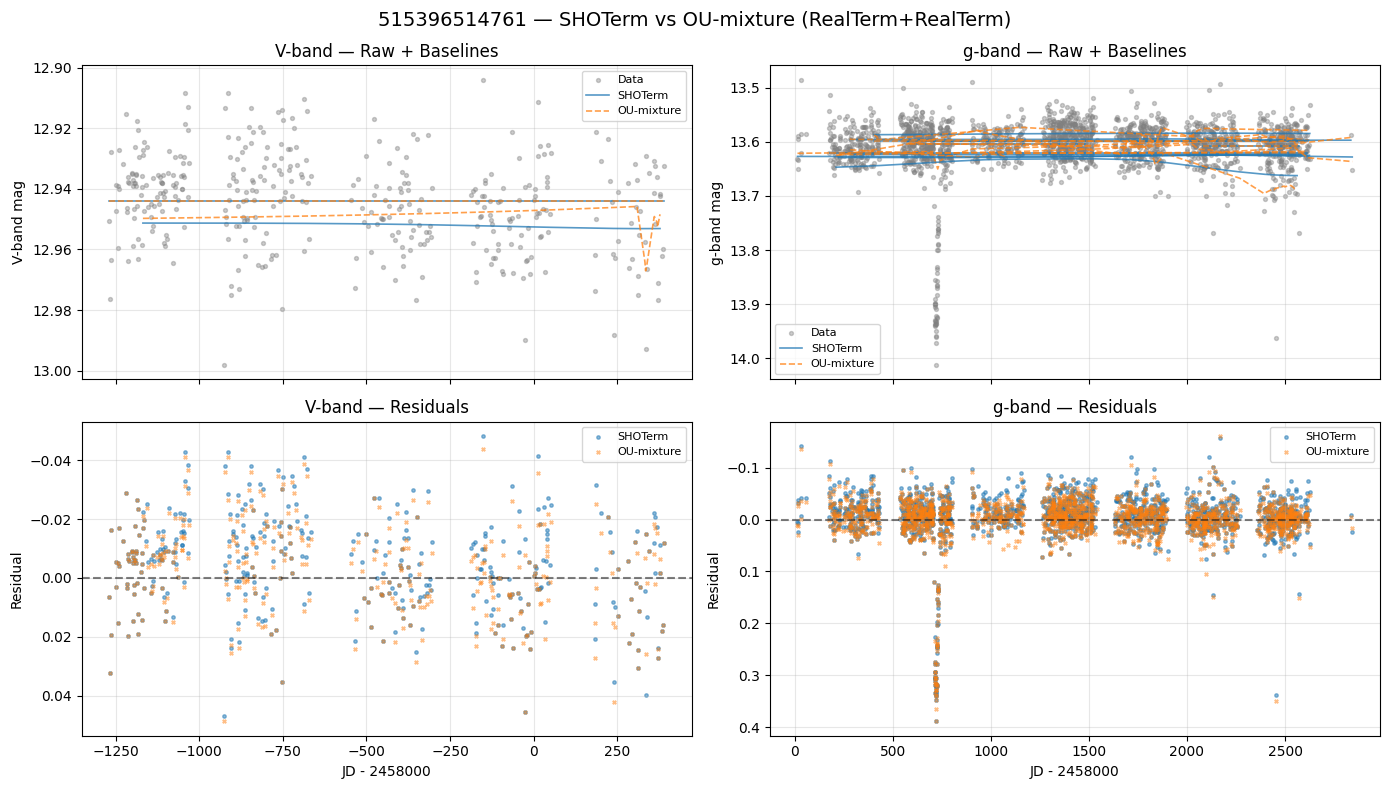

532576686103 V-band: SHOTerm 77 dips, OU-mixture 18 dips
532576686103 g-band: SHOTerm 888 dips, OU-mixture 386 dips


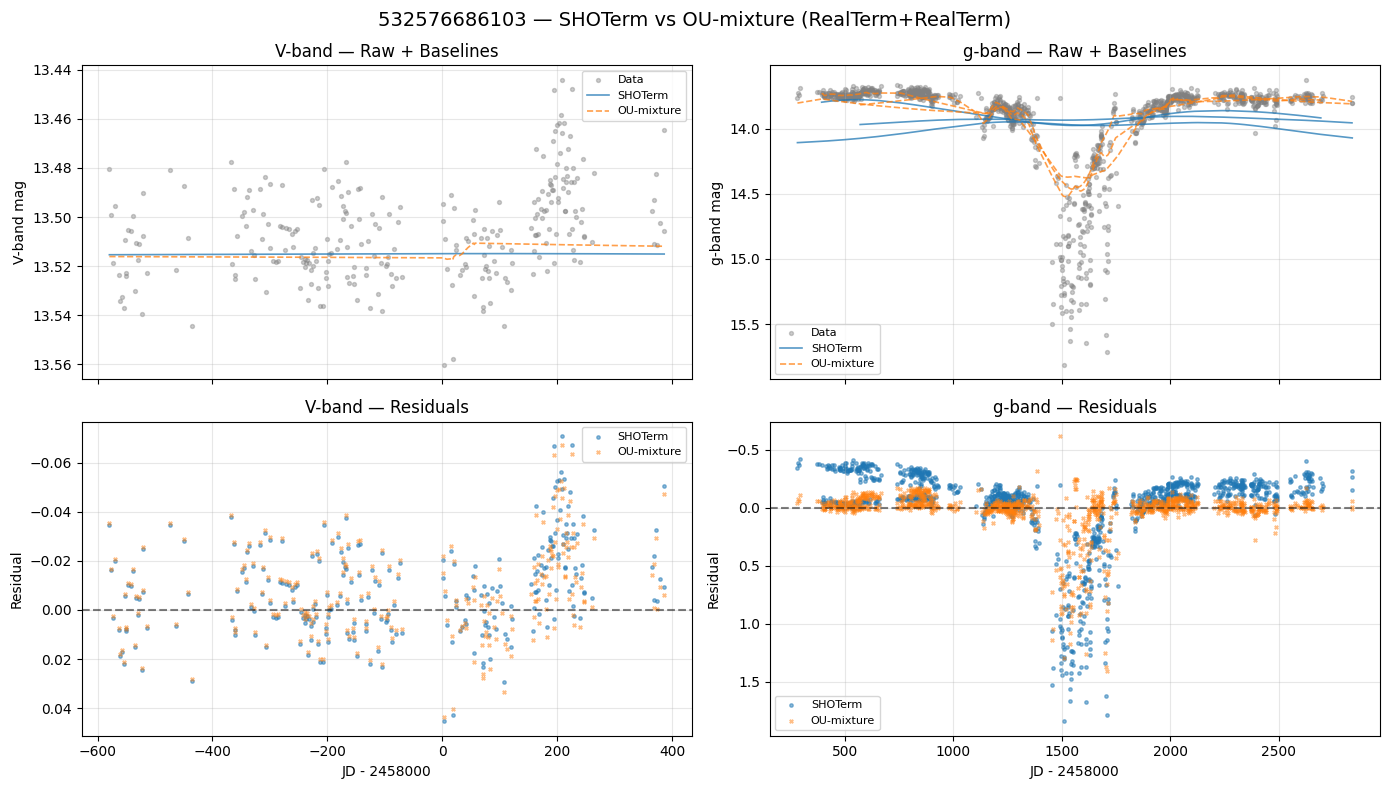

In [13]:
# Compare current SHO GP kernel vs a non-oscillatory red-noise GP (OU mixture)
# Recommendation for dip baselines: prefer OU-mixture (RealTerm + RealTerm) over SHO if you don't need quasi-periodicity.

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from celerite2 import terms
from df_plot import read_skypatrol_csv


def compare_sho_vs_ou(csv_path, sho_params=None, ou_params=None, mask_params=None):
    sho_params = sho_params or {"S0": 0.0005, "w0": 0.0031415926535897933, "Q": 0.7}

    # Two-timescale OU mixture: fast + slow red noise
    # Using fixed values that match the RealTerm params from GP Kwargs 1
    ou_params = ou_params or {
        "a_fast": 0.0004,  # a1
        "rho_fast": 1000.0,  # rho1
        "a_slow": 0.0001,  # a2
        "rho_slow": 3000.0,  # rho2
    }

    mask_params = mask_params or {"dip_sigma_thresh": -1.0, "pad_days": 100.0, "jitter": 0.006}

    df = read_skypatrol_csv(csv_path)
    source_id = Path(csv_path).stem.replace("-light-curves", "")

    # Build SHO kernel using S0, w0, Q parameterization
    if "S0" in sho_params and "w0" in sho_params:
        sho_kernel = terms.SHOTerm(S0=sho_params["S0"], w0=sho_params["w0"], Q=sho_params["Q"])
    else:
        # Fallback to sigma, rho for backward compatibility
        sho_kernel = terms.SHOTerm(sigma=sho_params["sigma"], rho=sho_params["rho"], Q=sho_params["Q"])
    ou_kernel = (
        terms.RealTerm(a=ou_params["a_fast"], c=1.0 / ou_params["rho_fast"]) +
        terms.RealTerm(a=ou_params["a_slow"], c=1.0 / ou_params["rho_slow"])
    )

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex='col')
    fig.suptitle(f"{source_id} — SHOTerm vs OU-mixture (RealTerm+RealTerm)", fontsize=14)

    for col, (band, band_name) in enumerate([(1, "V-band"), (0, "g-band")]):
        df_band = df[df["v_g_band"] == band].copy()
        if df_band.empty:
            for row in range(2):
                axes[row, col].text(0.5, 0.5, f"No {band_name} data", ha='center', va='center')
            continue

        res_sho = gp_baseline_with_kernel(df_band.copy(), sho_kernel, **mask_params)
        res_ou = gp_baseline_with_kernel(df_band.copy(), ou_kernel, **mask_params)

        jd = res_sho["JD"].values - 2458000
        mag = res_sho["mag"].values

        ax_top = axes[0, col]
        ax_top.scatter(jd, mag, s=8, alpha=0.4, c='gray', label='Data')

        # Plot per-camera baselines (sorted, duplicates collapsed)
        cams_here = sorted(res_sho["camera#"].dropna().unique())
        for i_cam, cam in enumerate(cams_here):
            sho_cam = res_sho[res_sho["camera#"] == cam][["JD", "baseline"]].dropna().copy()
            ou_cam = res_ou[res_ou["camera#"] == cam][["JD", "baseline"]].dropna().copy()

            if not sho_cam.empty:
                sho_cam["JD_plot"] = sho_cam["JD"].values - 2458000
                sho_cam = sho_cam.sort_values("JD_plot")
                if sho_cam["JD_plot"].duplicated().any():
                    sho_cam = sho_cam.groupby("JD_plot", as_index=False)["baseline"].median()
                ax_top.plot(
                    sho_cam["JD_plot"],
                    sho_cam["baseline"],
                    '-',
                    color='tab:blue',
                    lw=1.2,
                    alpha=0.75,
                    label='SHOTerm' if i_cam == 0 else None,
                )

            if not ou_cam.empty:
                ou_cam["JD_plot"] = ou_cam["JD"].values - 2458000
                ou_cam = ou_cam.sort_values("JD_plot")
                if ou_cam["JD_plot"].duplicated().any():
                    ou_cam = ou_cam.groupby("JD_plot", as_index=False)["baseline"].median()
                ax_top.plot(
                    ou_cam["JD_plot"],
                    ou_cam["baseline"],
                    '--',
                    color='tab:orange',
                    lw=1.2,
                    alpha=0.75,
                    label='OU-mixture' if i_cam == 0 else None,
                )

        ax_top.invert_yaxis()
        ax_top.set_ylabel(f"{band_name} mag")
        ax_top.set_title(f"{band_name} — Raw + Baselines")
        ax_top.legend(loc='best', fontsize=8)
        ax_top.grid(True, alpha=0.3)

        ax_bot = axes[1, col]
        ax_bot.scatter(jd, res_sho["resid"].values, s=6, alpha=0.5, c='tab:blue', marker='o', label='SHOTerm')
        ax_bot.scatter(jd, res_ou["resid"].values, s=6, alpha=0.5, c='tab:orange', marker='x', label='OU-mixture')
        ax_bot.axhline(0, color='k', linestyle='--', alpha=0.5)
        ax_bot.invert_yaxis()
        ax_bot.set_ylabel("Residual")
        ax_bot.set_xlabel("JD - 2458000")
        ax_bot.set_title(f"{band_name} — Residuals")
        ax_bot.legend(loc='best', fontsize=8)
        ax_bot.grid(True, alpha=0.3)

        n_sho = int((res_sho["sigma_resid"] < -3).sum())
        n_ou = int((res_ou["sigma_resid"] < -3).sum())
        print(f"{source_id} {band_name}: SHOTerm {n_sho} dips, OU-mixture {n_ou} dips")

    plt.tight_layout()
    plt.show()
    return fig


# Run on the same sources as above
# GP Kwargs 1 - do work: Using S0, w0, Q parameterization
_sho_params = {"S0": 0.0005, "w0": 0.0031415926535897933, "Q": 0.7}
if "gp_kwargs" in globals():
    # Map your per_camera_gp_baseline params -> SHO kernel params
    if "S0" in gp_kwargs and "w0" in gp_kwargs:
        _sho_params = {
            "S0": float(gp_kwargs.get("S0", _sho_params["S0"])),
            "w0": float(gp_kwargs.get("w0", _sho_params["w0"])),
            "Q": float(gp_kwargs.get("q", _sho_params["Q"])),
        }
    else:
        # Fallback: convert sigma, rho to S0, w0 if needed (or use defaults)
        _sho_params = {
            "S0": 0.0005,
            "w0": 0.0031415926535897933,
            "Q": float(gp_kwargs.get("q", _sho_params["Q"])),
        }

_mask_params = {"dip_sigma_thresh": -1.0, "pad_days": 100.0, "jitter": 0.006}

print("SHO kernel params:", _sho_params)
print("Mask params:", _mask_params)

for src in test_sources:
    compare_sho_vs_ou(src, sho_params=_sho_params, mask_params=_mask_params)

